# Data Analysis for Publication

This jupyter notebook contains the code needed to computationally reproduce the results and figures 1,3,5 (need to put in correct figure numbers) exhibited in Newall et al., (2026). Some exploratory analysis that may have contributed to our workflow but does not impact the results or figures has been left out for clarity.

## Overall Workflow

The workflow in this notebook is as follows.
- Quality Check Data
- Compute ASA for each core
- Perform Welch's t-test
- Produce overall figures

In [168]:
#import the necessary data tools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import statistics
plt.rcParams.update({'font.size': 10})
cm = 1/2.54


## Quality Check Data
Check whether any unique identifiers (i.e. Lab Codes) are duplicated. This should highlight if any data has been used for multiple cores.



In [169]:
#Input the names of all the cores we have data for into 'allcores'.
allcores = ['18-B1','18-P2','287-K2','305-A5','307-A3','308-A3','316-P3','316-T3','331-P1','331-T1','333-P2',\
            '333-T2','339-B2','339-P2','339-T2','340-B1','340-P1','340-T1','342-B1','342-P1','342-T1',\
            'BAIK13-1C','BAIK13-4F',\
            'BDP93-1','BDP93-2','BDP96-1','BDP96-2','BDP97-1','BDP98-1',\
            'BSS06-G2','323-PC1', 'BarguzinCore18',\
            'CON01-603-5','CON01-605-3','CON01-605-5','CON01-606-3',\
            'Ver.99 G-6','Ver93-2 St.4-PC','Ver94-5 St.16-PC','Ver94-5 St.16-Pilot','Ver94-5 St.19-PC',\
            'Ver94-5 St.22-GC','Ver96-2 St.3-GC','Ver96-2 St.7-Pilot','Ver96-2 St.7-PC', 'Ver97-1 St.6',\
            'VER93-2 St.24GC','VER98-1 St.5PC','VER98-1 St.5GC','VER98-1 St.6GC','VER99G12']

In [170]:
# #Set up dfall as an empty dataframe
# dfall = pd.DataFrame([])

# #Run through the cores to input the data wanted (in this case, just the radiocarbon data)
# for core in allcores:
#     #Set up the filename using the corename
#         filename = '/Users/samnewall/Library/CloudStorage/GoogleDrive-newall@ucsb.edu/My Drive/Baikal Radiocarbon/Individual Core Data/{}.xlsx'.format(core)
        
#         #Insert the radiocarbon data into 'rdata'. *Comment - this seems to automatically replace cells with 'NA' in the spreadsheet to cells with 'NaN' in python. These are not the same... How to stop this from happening?
#         rdata = pd.read_excel(filename, sheet_name = '14C.data', usecols = 'B:U', skiprows = 2)
#         #Remove the units row
#         rdata = rdata.drop([0], axis=0)
#         rdata.insert(0,'Core Name',core)
#         dfall = pd.concat([dfall, rdata], ignore_index=True)

In [171]:
# Path to the PANGAEA export (tab-delimited text)
datafile = "../data/Baikal_14C_data_updated17Nov25_copy.txt"  # or whatever relative path in your repo

# Read the data section of the PANGAEA file
# (skip the metadata block; the table header starts after line 95)
raw = pd.read_csv(datafile, sep="\t", skiprows=95)

# Name columns
raw.columns = [
    "Event", "Core Name", "Lab Code", "Sec_label",
    "", "Depth_bot_m",
    "Middle Depth", "Corrected Depth", "Thick_cm",
    "Material",
    "Value", "Error",
    "d13C_method",
    "d13C_permil", "d13C_error",
    "Carbon_content_percent", "Reference", "Comment"
]

# Filter to just the cores you care about
dfall = raw[raw["Core Name"].isin(allcores)].copy()

#Convert necessary columns to numerics
cols_to_convert = ["Middle Depth", "Corrected Depth", "Value", "Error"]
for c in cols_to_convert:
    dfall[c] = pd.to_numeric(dfall[c], errors="coerce")


In [172]:
print('We have ' + str(len(allcores)) + ' cores and ' + str(len(dfall['Middle Depth'])) + ' radiocarbon datapoints.')

We have 51 cores and 509 radiocarbon datapoints.


Check for Lab Code Uniqueness

In [173]:
pd.concat(g for _, g in dfall.groupby("Lab Code") if len(g) > 1)

,Event,Core Name,Lab Code,Sec_label,,Depth_bot_m,Middle Depth,Corrected Depth,Thick_cm,Material,Value,Error,d13C_method,d13C_permil,d13C_error,Carbon_content_percent,Reference,Comment
453,VER99G12,VER99G12,NUTA2-10723,NaN,1.67,1.68,1.675,NaN,1,TOC,11.105,0.049,NaN,-26.7,NaN,1.57,Watanabe et al. (2009b),NaN
497,VER99G12,VER99G12,NUTA2-10723,NaN,4.6,4.61,4.605,NaN,1,TOC,27.162,0.130,NaN,-26.4,NaN,0.94,Watanabe et al. (2009b),NaN
417,VER98-1_St.6GC,VER98-1 St.6GC,NUTA2-5717,PA-34,0.33,0.34,0.335,NaN,1,TOC,7.019,0.035,NaN,NaN,NaN,NaN,"Watanabe et al., 2009a",NaN
437,VER98-1_St.6GC,VER98-1 St.6GC,NUTA2-5717,PB-75,1.49,1.5,1.495,NaN,1,TOC,27.383,0.117,NaN,NaN,NaN,NaN,"Watanabe et al., 2009a",NaN


Show histogram of dates/core

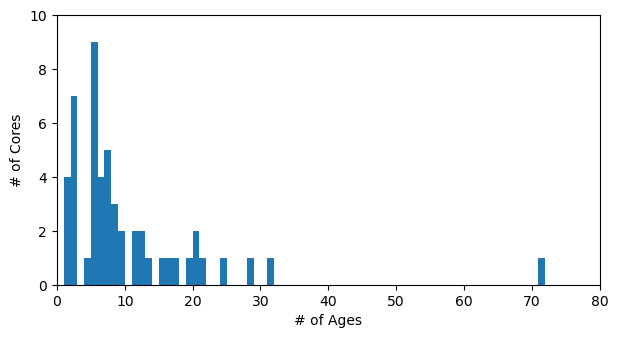

In [175]:
CoreCounts = dfall.pivot_table(columns=['Core Name'], aggfunc='size')
fig_agedenshist = plt.figure(1, figsize=(7,3.5))
CoreCounts.hist(bins = 80, range = [0, 80])
plt.ylabel('# of Cores')
plt.xlabel('# of Ages')
plt.xlim(0,80)
plt.ylim(0,10)
plt.grid(False)
plt.show()

## Listing Materials

Next, let us check what materials have been used and how many analyses have been done using each of them.

In [176]:
mats = dfall['Material'].value_counts()
print(mats)

TOC                   434
Pollen Concentrate     42
Total Lipids            9
Bulk Silty Clay         8
POM                     7
FOM                     5
Lipid fraction          2
Wood                    2
Name: Material, dtype: int64


## Negative or Non-Numeric Ages

Do some large-scale data quality checks. For example, are there any dates with negative ages (these can't be reliable), non-numeric age values (i.e. '<35000'), or exceptional d13C/carbon content values?

In [181]:
#Here we will check for both negative and non-numeric age values.

#First, set up some empty vectors
dfall_age = pd.Series([], dtype='float64')
negvals = pd.Series([], dtype='float64')
negcodes = pd.Series([], dtype='str')
nonnums = pd.Series([], dtype='str')
nonnumcodes = pd.Series([], dtype='str')

#Run through checking for negative and string values for 'Value'.
for i in range(len(dfall['Lab Code'])):
    if not isinstance(dfall['Value'].iloc[i], str):
        if dfall['Value'].iloc[i] < 0:
            negvals = pd.concat([negvals, pd.Series([dfall['Value'].iloc[i]])], ignore_index=True)
            negcodes = pd.concat([negcodes, pd.Series([dfall['Lab Code'].iloc[i]])], ignore_index=True)
    else:
        nonnums = pd.concat([nonnums, pd.Series([dfall['Value'].iloc[i]])], ignore_index=True)
        nonnumcodes = pd.concat([nonnumcodes, pd.Series([dfall['Lab Code'].iloc[i]])], ignore_index=True)

#Set up a record of labcodes that should be kept out of future analyses
xcodes = pd.concat([negcodes, nonnumcodes], ignore_index=True)

#Let us here remove these dates from 'dfall' using their lab codes as stored in the variable 'xcodes'
dfall = dfall.loc[~dfall['Lab Code'].isin(xcodes)]

In [182]:
print('We have ' + str(len(allcores)) + ' cores and ' + str(len(dfall['Value'])) + ' radiocarbon datapoints.')

We have 50 cores and 505 radiocarbon datapoints.


## All Core Plots

Produce figure that shows radiocarbon data for every core. Can then see which ones are linear, which don't have ages younger than 13k, etc, at a quick glance.



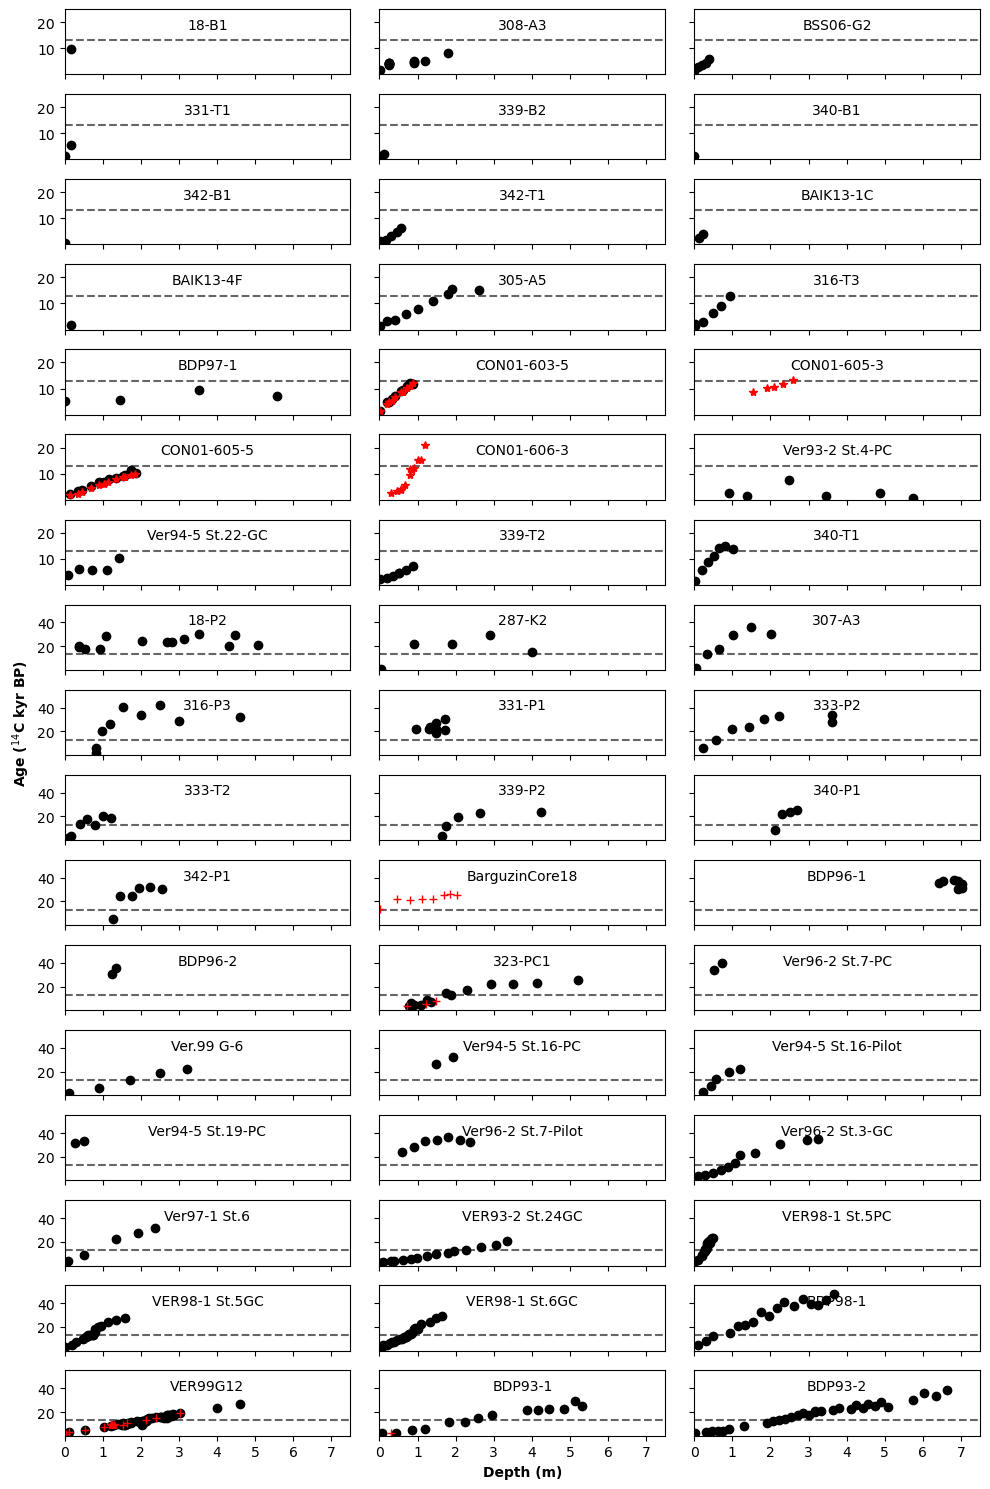

In [190]:
allcores = ['18-B1','18-P2','287-K2','305-A5','307-A3','308-A3','316-P3','316-T3','331-P1','331-T1','333-P2',\
            '333-T2','339-B2','339-P2','339-T2','340-B1','340-P1','340-T1','342-B1','342-P1','342-T1',\
            'BAIK13-1C','BAIK13-4F',\
            'BDP93-1','BDP93-2','BDP96-1','BDP96-2','BDP97-1','BDP98-1',\
            'BSS06-G2','323-PC1',\
            'CON01-603-5','CON01-605-3','CON01-605-5','CON01-606-3',\
            'Ver.99 G-6','Ver93-2 St.4-PC','Ver94-5 St.16-PC','Ver94-5 St.16-Pilot','Ver94-5 St.19-PC',\
            'Ver94-5 St.22-GC','Ver96-2 St.3-GC','Ver96-2 St.7-Pilot','Ver96-2 St.7-PC', 'Ver97-1 St.6',\
            'VER93-2 St.24GC','VER98-1 St.5PC','VER98-1 St.5GC','VER98-1 St.6GC','VER99G12']
 

youngcores = ['18-B1', '308-A3', 'BSS06-G2', '331-T1', '339-B2','340-B1', '342-B1',\
              '342-T1', 'BAIK13-1C', 'BAIK13-4F', '305-A5','316-T3', 'BDP97-1', \
              'CON01-603-5','CON01-605-3','CON01-605-5','CON01-606-3', 'Ver93-2 St.4-PC', \
              'Ver94-5 St.22-GC',  '339-T2','340-T1' ]
    
longcores = ['18-P2','287-K2','307-A3','316-P3','331-P1','333-P2',\
            '333-T2','339-P2','340-P1','342-P1',\
            'BarguzinCore18','BDP96-1','BDP96-2','323-PC1',\
            'Ver96-2 St.7-PC','Ver.99 G-6','Ver94-5 St.16-PC','Ver94-5 St.16-Pilot','Ver94-5 St.19-PC',\
            'Ver96-2 St.7-Pilot','Ver96-2 St.3-GC', 'Ver97-1 St.6',\
            'VER93-2 St.24GC','VER98-1 St.5PC','VER98-1 St.5GC','VER98-1 St.6GC','BDP98-1','VER99G12','BDP93-1','BDP93-2']
    
    
AR_ASAcores = ['Ver94-5 St.16-PC', '333-P2', '333-T2', '331-T1', '340-P1', '340-T1',\
            'Ver96-2 St.3-GC', 'VER98-1 St.6GC', 'VER98-1 St.5GC', 'Ver97-1 St.6', 'BDP98-1']  

BS_nonASAcores = ['BDP93-1', '339-P2', '316-P3']

BS_ASAcores = ['316-T3', 'BSS06-G2', '339-T2', '339-B2', 'BDP93-2', '305-A5', 'VER93-2 St.24GC', 'VER99G12']

# '.' for dot; 'o' for circle, 'v' for trinagle down, '+' for plus
plotstyles1 = ['ok', '*r', '+r', 'ok', 'ok', '+r', '+r', '+r', '+r']

def allplots(core_names, plotstyles, plotrows, plotcolumns, dfall):
    fig, axs = plt.subplots(plotrows, plotcolumns)
    fig.set_figheight(15)
    fig.set_figwidth(10)
    
    materials = [
        'TOC', 'Pollen Concentrate', 'Total Lipids', 'POM', 'FOM',
        'Wood', 'Lipid fraction', 'Bulk Silty Clay'
    ]
    
    for j, core in enumerate(core_names):
        fig_a, fig_b = divmod(j, plotcolumns)
        ax = axs[fig_a, fig_b]
        
        # subset to this core once
        rdata_core = dfall[dfall['Core Name'] == core].copy()
        if rdata_core.empty:
            ax.set_title(core + " (no data)")
            continue
        
        for i, mat in enumerate(materials):
            rd_toc = rdata_core[rdata_core['Material'] == mat].copy()
            if rd_toc.empty:
                continue
            
            # keep only rows with numeric Value and Error
            rd_toc = rd_toc[rd_toc['Value'].notna() & rd_toc['Error'].notna()]
            if rd_toc.empty:
                continue
            
            # choose depth column: prefer Corrected Depth if any numeric values exist
            use_corrected = rd_toc['Corrected Depth'].notna().any()
            if use_corrected:
                x = rd_toc['Corrected Depth']
            else:
                x = rd_toc['Middle Depth']
            
            y = rd_toc['Value']   # already in 14C kyr BP
            yerror = rd_toc['Error']  # kyr
            
            if x.empty or y.empty:
                continue
            
            fmt = plotstyles[i] if i < len(plotstyles) else '.'
            ax.errorbar(x, y, yerr=yerror, fmt=fmt)
        
        # young vs long cores
        youngAxes = fig_a in [0, 1, 2, 3, 4, 5, 6]
        if youngAxes:
            ylims = [0, 25]   # 0–25 kyr
            ax.set_ylim(ylims)
            ax.text(3.75, ylims[1]*0.7, core, horizontalalignment="center")
        else:
            ylims = [0, 55]   # 0–55 kyr
            ax.set_ylim(ylims)
            ax.text(3.75, ylims[1]*0.7, core, horizontalalignment="center")
        
        # y-ticks now in kyr
        if fig_b == 0 and youngAxes:
            ax.set_yticks([10, 20], ["10", "20"])
        elif fig_b != 0 and youngAxes:
            ax.set_yticks([10, 20], [" ", " "])
        elif fig_b == 0 and not youngAxes:
            ax.set_yticks([20, 40], ["20", "40"])
        elif fig_b != 0 and not youngAxes:
            ax.set_yticks([20, 40], [" ", " "])
        
        # x-ticks and x-label
        if fig_a == 16:
            ax.set_xticks(
                [0, 1, 2, 3, 4, 5, 6, 7],
                ["0", "1", "2", "3", "4", "5", "6", "7"]
            )
        else:
            ax.set_xticks(
                [0, 1, 2, 3, 4, 5, 6, 7],
                ["", "", "", "", "", "", "", ""]
            )
        
        if fig_b == 0 and fig_a == 8:
            ax.set_ylabel('Age ($^{14}$C kyr BP)', fontweight='bold')
        
        if fig_b == 1 and fig_a == 16:
            ax.set_xlabel('Depth (m)', fontweight='bold')
        
        ax.set_xlim([0, 7.5])
        ax.axhline(13, color='0.4', linestyle='--')
        #ax.set_title(core_names[j])
    
    plt.tight_layout()

allplots(youngcores+longcores, plotstyles1, 17, 3, dfall)


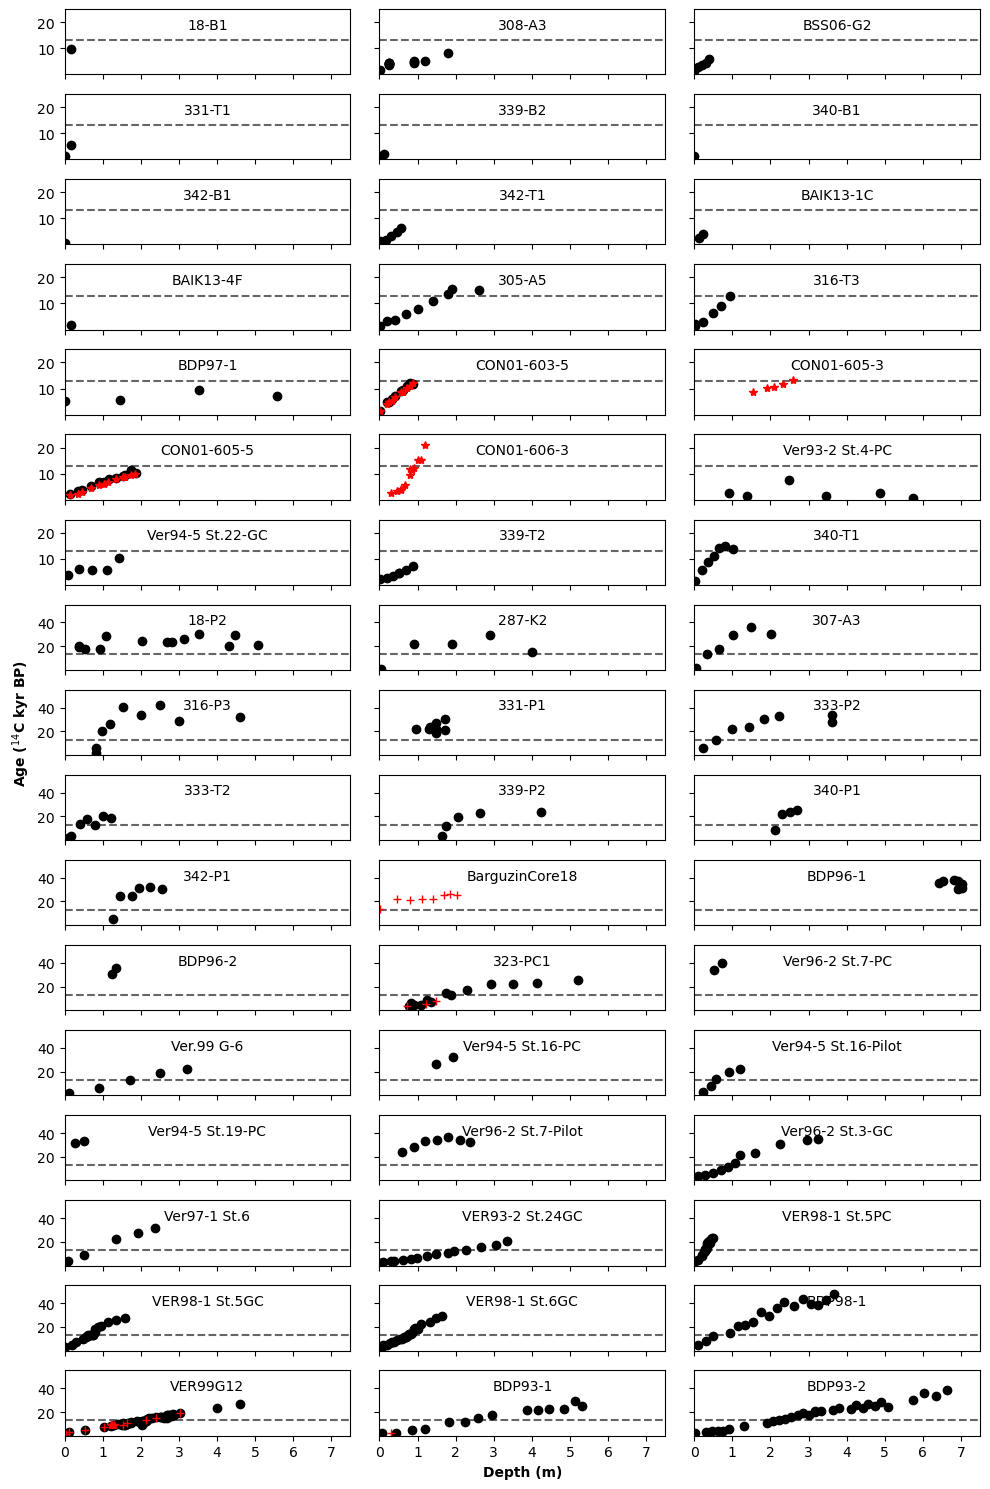

In [368]:

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

allcores = ['18-B1','18-P2','287-K2','305-A5','307-A3','308-A3','316-P3','316-T3','331-P1','331-T1','333-P2',\
            '333-T2','339-B2','339-P2','339-T2','340-B1','340-P1','340-T1','342-B1','342-P1','342-T1',\
            'BAIK13-1C','BAIK13-4F',\
            'BDP93-1','BDP93-2','BDP96-1','BDP96-2','BDP97-1','BDP98-1',\
            'BSS06-G2','323-PC1',\
            'CON01-603-5','CON01-605-3','CON01-605-5','CON01-606-3',\
            'Ver.99 G-6','Ver93-2 St.4-PC','Ver94-5 St.16-PC','Ver94-5 St.16-Pilot','Ver94-5 St.19-PC',\
            'Ver94-5 St.22-GC','Ver96-2 St.3-GC','Ver96-2 St.7-Pilot','Ver96-2 St.7-PC', 'Ver97-1 St.6',\
            'VER93-2 St.24GC','VER98-1 St.5PC','VER98-1 St.5GC','VER98-1 St.6GC','VER99G12']
 

youngcores = ['18-B1', '308-A3', 'BSS06-G2', '331-T1', '339-B2','340-B1', '342-B1',\
              '342-T1', 'BAIK13-1C', 'BAIK13-4F', '305-A5','316-T3', 'BDP97-1', \
              'CON01-603-5','CON01-605-3','CON01-605-5','CON01-606-3', 'Ver93-2 St.4-PC', \
              'Ver94-5 St.22-GC',  '339-T2','340-T1' ]
    
longcores = ['18-P2','287-K2','307-A3','316-P3','331-P1','333-P2',\
            '333-T2','339-P2','340-P1','342-P1',\
            'BarguzinCore18','BDP96-1','BDP96-2','323-PC1',\
            'Ver96-2 St.7-PC','Ver.99 G-6','Ver94-5 St.16-PC','Ver94-5 St.16-Pilot','Ver94-5 St.19-PC',\
            'Ver96-2 St.7-Pilot','Ver96-2 St.3-GC', 'Ver97-1 St.6',\
            'VER93-2 St.24GC','VER98-1 St.5PC','VER98-1 St.5GC','VER98-1 St.6GC','BDP98-1','VER99G12','BDP93-1','BDP93-2']
    
    
AR_ASAcores = ['Ver94-5 St.16-PC', '333-P2', '333-T2', '331-T1', '340-P1', '340-T1',\
            'Ver96-2 St.3-GC', 'VER98-1 St.6GC', 'VER98-1 St.5GC', 'Ver97-1 St.6', 'BDP98-1']  

BS_nonASAcores = ['BDP93-1', '339-P2', '316-P3']

BS_ASAcores = ['316-T3', 'BSS06-G2', '339-T2', '339-B2', 'BDP93-2', '305-A5', 'VER93-2 St.24GC', 'VER99G12']

# '.' for dot; 'o' for circle, 'v' for trinagle down, '+' for plus
plotstyles1 = ['ok', '*r', '+r', 'ok', 'ok', '+r', '+r', '+r', '+r']

def allplots(core_names, plotstyles, plotrows, plotcolumns, dfall):
    fig, axs = plt.subplots(plotrows, plotcolumns, squeeze=False)
    fig.set_figheight(15)
    fig.set_figwidth(10)
    
    materials = [
        'TOC', 'Pollen Concentrate', 'Total Lipids', 'POM', 'FOM',
        'Diatom/Pelitic Silt', 'Wood', 'Lipid fraction', 'Bulk Silty Clay'
    ]
    
    for j, core in enumerate(core_names):
        fig_a, fig_b = divmod(j, plotcolumns)
        ax = axs[fig_a, fig_b]
        
        # subset to this core once
        rdata_core = dfall[dfall['Core Name'] == core].copy()
        if rdata_core.empty:
            ax.set_title(core + " (no data)")
            continue
        
        for i, mat in enumerate(materials):
            rd_toc = rdata_core[rdata_core['Material'] == mat].copy()
            if rd_toc.empty:
                continue
            
            # keep only rows with numeric Value and Error
            rd_toc = rd_toc[rd_toc['Value'].notna() & rd_toc['Error'].notna()]
            if rd_toc.empty:
                continue
            
            # choose depth column: prefer Corrected Depth if any numeric values exist
            use_corrected = rd_toc['Corrected Depth'].notna().any()
            if use_corrected:
                x = rd_toc['Corrected Depth']
            else:
                x = rd_toc['Middle Depth']
            
            y = rd_toc['Value']   # already in 14C kyr BP
            yerror = rd_toc['Error']  # kyr
            
            if x.empty or y.empty:
                continue
            
            fmt = plotstyles[i] if i < len(plotstyles) else '.'
            ax.errorbar(x, y, yerr=yerror, fmt=fmt)
        
        # young vs long cores layout logic (now in kyr)
        youngAxes = fig_a in [0, 1, 2, 3, 4, 5, 6]
        if youngAxes:
            ylims = [0, 25]   # 0–25 kyr instead of 0–25000 yr
            ax.set_ylim(ylims)
            ax.text(3.75, ylims[1]*0.7, core, horizontalalignment="center")
        else:
            ylims = [0, 55]   # 0–55 kyr instead of 0–55000 yr
            ax.set_ylim(ylims)
            ax.text(3.75, ylims[1]*0.7, core, horizontalalignment="center")
        
        # y-ticks now in kyr
        if fig_b == 0 and youngAxes:
            ax.set_yticks([10, 20], ["10", "20"])
        elif fig_b != 0 and youngAxes:
            ax.set_yticks([10, 20], [" ", " "])
        elif fig_b == 0 and not youngAxes:
            ax.set_yticks([20, 40], ["20", "40"])
        elif fig_b != 0 and not youngAxes:
            ax.set_yticks([20, 40], [" ", " "])
        
        # x-ticks and x-label
        if fig_a == 16:
            ax.set_xticks(
                [0, 1, 2, 3, 4, 5, 6, 7],
                ["0", "1", "2", "3", "4", "5", "6", "7"]
            )
        else:
            ax.set_xticks(
                [0, 1, 2, 3, 4, 5, 6, 7],
                ["", "", "", "", "", "", "", ""]
            )
        
        if fig_b == 0 and fig_a == 8:
            ax.set_ylabel('Age ($^{14}$C kyr BP)', fontweight='bold')
        
        if fig_b == 1 and fig_a == 16:
            ax.set_xlabel('Depth (m)', fontweight='bold')
        
        ax.set_xlim([0, 7.5])
        ax.axhline(13, color='0.4', linestyle='--')
    
    plt.tight_layout()




allplots(youngcores+longcores, plotstyles1, 17, 3, dfall)
#allplots(AR_ASAcores, plotstyles1, 4, 5)

#allplots(BS_ASAcores, plotstyles1, 4,4)
#plt.savefig('allCores.pdf', bbox_inches = 'tight', dpi = 300)


## Compute ASA for each core

In this section, we first define the relevant functions for computing the ASA for each core.

Then, we go through each core and plot the data, choose if any dates need to be removed before analysis, then perform the computation.

As a reminder, whilst we have 51 cores in the dataset, some of the cores will be evaluated together because they are all from the same site, so there will not be 51 analyses of ASA.

Here is a list of the sites we will perform ASA at, highlighting where cores will be combined or not.

__Buguldeika Saddle__
- 305-A5
- BSS06-G2
- Site316 (316-P3, 316-T3)
- Site339 (339-P2, 339-T2, 339-B2)
- VER93-2 St.24GC
- VER99G12
- BDP93 (BDP93-1, BDP93-2)

__Academician Ridge__
- BDP98-1
- Site18 (18-P2, 18-B1)
- Site331 (331-P1, 331-T1)
- Site333 (333-T2, 333-P2)
- Site340 (340-B1, 340-T1, 340-P1)
- 307-A3
- VER98St5 (VER98-1 St.5GC, VER98-1 St.5PC)
- VER98-1 St.6GC
- Ver97-1 St.6
- VER96-2 St.3-GC
- VER96St7 (Ver96-2 St.7-Pilot, Ver96-2 St.7-PC)
- VER94St16 (Ver94-5 St.16-Pilot, Ver94-5 St.16-PC)
- VER94-5 st.19-PC
- VER93-2 st.4-PC

__Maloe More__
- Site342 (342-B1, 342-T1, 342-P1)

__Continent Ridge__
- CON01-603-5

__Posolskoe Bank__
- Ver.99 G-6
- (CON01-606-3 not considered - Pollen Ages only)

__Vydrino Shoulder__
- CON01-605-5
- (CON01-605-3 not considered - Pollen Ages only)

__North Basin__
- 323-PC1
- Ver94-5 St.22-GC

__Central Basin__
- 308-A3

__Southern Basin__
- BAIK13-1C
- BAIK13-4F (Only 1 Age)
- BDP97-1


In [369]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

#Stealing a definition for a linear regression function from the web...
def linear_regression(x, y):     
    N = len(x)
    x_mean = x.mean()
    y_mean = y.mean()
    
    B1_num = ((x - x_mean) * (y - y_mean)).sum()
    B1_den = ((x - x_mean)**2).sum()
    B1 = B1_num / B1_den
    
    B0 = y_mean - (B1*x_mean)
    
    reg_line = 'y = {} + {}x'.format(B0, round(B1, 3))
    
    return (B0, B1, reg_line)

def compiplot(core_names, xlabcodes, dfall):
    """
    Plot compiled radiocarbon ages for a set of cores using a single
    dataframe `dfall` that contains all Baikal 14C data.

    Parameters
    ----------
    core_names : list of str
        Core names to include (must match dfall['Core Name']).
    xlabcodes : list of str
        Lab codes to exclude from plotting.
    dfall : pandas.DataFrame
        Master dataframe with all radiocarbon data.
    """
    legendl = []
    xc = pd.Series([], dtype='float64')
    yc = pd.Series([], dtype='float64')

    for core in core_names:
        # subset to this core
        rdata = dfall[dfall['Core Name'] == core].copy()

        # keep only TOC/FOM/POM
        rdata = rdata[
            (rdata['Material'] == 'TOC') |
            (rdata['Material'] == 'FOM') |
            (rdata['Material'] == 'POM')
        ]

        # keep only rows with numeric error (NaN = drop)
        rdata = rdata[rdata['Error'].notna()]

        # remove specific lab codes
        if len(xlabcodes) > 0:
            rdata = rdata[~rdata['Lab Code'].isin(xlabcodes)]

        # decide which depth column to use: corrected depth if any numeric values exist
        if rdata['Corrected Depth'].notna().any():
            x = rdata['Corrected Depth']
        else:
            x = rdata['Middle Depth']

        # y = age value and yerror = error
        y = rdata['Value']
        yerror = rdata['Error']

        # update axis limits bookkeeping
        xc = pd.concat([xc, x])
        yc = pd.concat([yc, y])

        # plot this core
        plt.errorbar(x, y, yerr=yerror, fmt='.')
        legendl.append(core)

    # axis labels and limits
    if len(xc) > 0 and len(yc) > 0:
        plt.xlabel('Depth (cm)')
        plt.ylabel('Age (14C yr BP)')
        plt.xlim(0, 1.1 * xc.max())
        plt.ylim(0, 1.1 * yc.max())
        plt.legend(legendl, loc=0)
        
        
def compiplot_grey(core_names, xlabcodes, dfall):
    """
    Plot compiled radiocarbon ages (with grey >13k and marked rejections)
    for a set of cores using a single dataframe `dfall`.

    Parameters
    ----------
    core_names : list of str
        Core names to include (must match dfall['Core Name']).
    xlabcodes : list of str
        Lab codes to exclude (plotted separately as 'Rejected').
    dfall : pandas.DataFrame
        Master dataframe with all radiocarbon data.
    """
    legendl = []
    xc_all = pd.Series([], dtype='float64')
    xc      = pd.Series([], dtype='float64')
    xcGrey  = pd.Series([], dtype='float64')
    xcXcode = pd.Series([], dtype='float64')
    yc      = pd.Series([], dtype='float64')
    yc_all  = pd.Series([], dtype='float64')
    ycerror = pd.Series([], dtype='float64')
    ycGrey  = pd.Series([], dtype='float64')
    ycerrorGrey  = pd.Series([], dtype='float64')
    ycXcode      = pd.Series([], dtype='float64')
    ycerrorXcode = pd.Series([], dtype='float64')

    for core in core_names:
        # subset to this core
        rdata = dfall[dfall['Core Name'] == core].copy()
        if rdata.empty:
            continue  # nothing to plot for this core

        # TOC/FOM/POM only
        rd_tocall = rdata[
            (rdata['Material'] == 'TOC') |
            (rdata['Material'] == 'FOM') |
            (rdata['Material'] == 'POM')
        ].copy()
        if rd_tocall.empty:
            continue

        # keep only rows with numeric error
        rd_tocerror = rd_tocall[rd_tocall['Error'].notna()].copy()
        if rd_tocerror.empty:
            continue

        # split into kept vs excluded (xlabcodes)
        rd_toc      = rd_tocerror[~rd_tocerror['Lab Code'].isin(xlabcodes)].copy()
        rd_tocXcode = rd_tocerror[ rd_tocerror['Lab Code'].isin(xlabcodes)].copy()

        if rd_toc.empty and rd_tocXcode.empty:
            continue

        # younger vs older than 13,000 14C yr BP
        rd_toc13  = rd_toc[rd_toc['Value'] < 13].copy()
        rd_tocg13 = rd_toc[rd_toc['Value'] >= 13].copy()

        # decide which depth column to use (prefer corrected if any numeric)
        use_corrected = rd_tocall['Corrected Depth'].notna().any()

        if use_corrected:
            x_all  = rd_tocall['Corrected Depth']
            x      = rd_toc13['Corrected Depth']
            xGrey  = rd_tocg13['Corrected Depth']
            xXcode = rd_tocXcode['Corrected Depth']
        else:
            x_all  = rd_tocall['Middle Depth']
            x      = rd_toc13['Middle Depth']
            xGrey  = rd_tocg13['Middle Depth']
            xXcode = rd_tocXcode['Middle Depth']

        # y values in 14C kyr BP
        y_all  = rd_tocall['Value']
        y      = rd_toc13['Value']
        yGrey  = rd_tocg13['Value'] 
        yXcode = rd_tocXcode['Value']

        # errors in kyr
        yerror      = rd_toc13['Error']  
        yerrorGrey  = rd_tocg13['Error']   
        yerrorXcode = rd_tocXcode['Error'] 

        # accumulate for global limits
        xc_all = pd.concat([xc_all, x_all])
        yc_all = pd.concat([yc_all, y_all])
        xc     = pd.concat([xc, x])
        yc     = pd.concat([yc, y])
        xcGrey = pd.concat([xcGrey, xGrey])
        ycGrey = pd.concat([ycGrey, yGrey])
        xcXcode = pd.concat([xcXcode, xXcode])
        ycXcode = pd.concat([ycXcode, yXcode])
        ycerror      = pd.concat([ycerror, yerror])
        ycerrorGrey  = pd.concat([ycerrorGrey, yerrorGrey])
        ycerrorXcode = pd.concat([ycerrorXcode, yerrorXcode])

        # legend entries
        legendl.append(core)
        if core != core_names[-1]:
            legendl.append('_nolegend_')
            legendl.append('_nolegend_')
        else:
            legendl.append('>13 $^{14}$C kyr BP')
            legendl.append('Rejected')

        # main errorbar: all points, coloured by age/rejection via separate markers
        plt.errorbar(
            pd.concat([x, xGrey, xXcode]),
            pd.concat([y, yGrey, yXcode]),
            yerr=pd.concat([yerror, yerrorGrey, yerrorXcode]),
            fmt='.', ms=8
        )
        # grey points (older than 13k)
        plt.errorbar(xGrey,  yGrey,  yerr=0, fmt='x', color='0.6')
        # rejected points (xlabcodes)
        plt.errorbar(xXcode, yXcode, yerr=0, fmt='x', color='0')

        plt.xlabel('Depth (m)')
        plt.ylabel('Age ($^{14}$C kyr BP)')

    if not xc_all.empty and not yc_all.empty:
        plt.xlim(0, 1.1 * xc_all.max())
        plt.ylim(0, 1.1 * yc_all.max())
    plt.legend(legendl, loc=0)

def ASA13_grey(core_names, xlabcodes, dfall):
    """
    Compute ASA using only data in dfall, and plot using compiplot_grey.

    Parameters
    ----------
    core_names : list of str
        Core names to include (must match dfall['Core Name']).
    xlabcodes : list of str
        Lab codes to exclude from the regression and mark as rejected.
    dfall : pandas.DataFrame
        Master dataframe with all radiocarbon data.

    Returns
    -------
    float or str
        ASA (intercept, in 14C kyr BP) if regression is possible,
        otherwise a message.
    """

    # Set up empty vectors to store combined depth/age data
    xC = pd.Series([], dtype='float64')
    yC = pd.Series([], dtype='float64')

    for core in core_names:
        # subset to this core
        rdata = dfall[dfall['Core Name'] == core].copy()
        if rdata.empty:
            continue

        # choose only TOC/FOM/POM
        rd_toc = rdata[
            (rdata['Material'] == 'TOC') |
            (rdata['Material'] == 'FOM') |
            (rdata['Material'] == 'POM')
        ].copy()
        if rd_toc.empty:
            continue

        # keep only rows with a non-missing lab code
        rd_toc = rd_toc[rd_toc['Lab Code'].notna()].copy()
        if rd_toc.empty:
            continue

        # keep only rows with numeric error
        rd_toc = rd_toc[rd_toc['Error'].notna()].copy()
        if rd_toc.empty:
            continue

        # remove specific data points by lab code
        if len(xlabcodes) > 0:
            rd_toc = rd_toc[~rd_toc['Lab Code'].isin(xlabcodes)].copy()
        if rd_toc.empty:
            continue

        # select only data younger than 13,000 14C yr BP
        rd_toc13 = rd_toc[rd_toc['Value'] < 13].copy()
        if rd_toc13.empty:
            continue

        # choose depth column: prefer corrected depth if any numeric values exist
        use_corrected = rd_toc13['Corrected Depth'].notna().any()
        if use_corrected:
            x = rd_toc13['Corrected Depth']
        else:
            x = rd_toc13['Middle Depth']

        # age in 14C kyr BP
        y = rd_toc13['Value']

        xC = pd.concat([xC, x])
        yC = pd.concat([yC, y])

    # Need at least 2 points for a regression
    if len(xC) > 1:
        lin = linear_regression(xC, yC)

        # make the grey plot using the dfall-based version
        figasa = compiplot_grey(core_names, xlabcodes, dfall)

        # regression line up to 13 kyr
        xlin = np.linspace(0, (13 - lin[0]) / lin[1], 10)
        ylin = lin[1] * xlin + lin[0]
        plt.plot(xlin, ylin, '--', linewidth=0.7, color='0')

        ax = plt.gca()
        plt.text(
            0.85, 0.4,
            "ASA = " + str(round(lin[0], 3)),
            horizontalalignment='center',
            verticalalignment='center',
            transform=ax.transAxes
        )

        return lin[0]
    else:
        return 'Not enough data younger than 13 14C ky BP to perform linear regression'

def ASAall(core_names, xlabcodes, dfall):

    #Set up empty vectors to store the important info
    xC = pd.Series([], dtype='int32')
    yC = pd.Series([], dtype='int32')

    for core in core_names:
        # subset to this core
        rdata = dfall[dfall['Core Name'] == core].copy()
        if rdata.empty:
            continue

        # choose only TOC/FOM/POM
        rd_toc = rdata[
            (rdata['Material'] == 'TOC') |
            (rdata['Material'] == 'FOM') |
            (rdata['Material'] == 'POM')
        ].copy()
        if rd_toc.empty:
            continue

        # keep only rows with a non-missing lab code
        rd_toc = rd_toc[rd_toc['Lab Code'].notna()].copy()
        if rd_toc.empty:
            continue

        # keep only rows with numeric error
        rd_toc = rd_toc[rd_toc['Error'].notna()].copy()
        if rd_toc.empty:
            continue

        # remove specific data points by lab code
        if len(xlabcodes) > 0:
            rd_toc = rd_toc[~rd_toc['Lab Code'].isin(xlabcodes)].copy()
        if rd_toc.empty:
            continue

        # choose depth column: prefer corrected depth if any numeric values exist
        use_corrected = rd_toc['Corrected Depth'].notna().any()
        if use_corrected:
            x = rd_toc['Corrected Depth']
        else:
            x = rd_toc['Middle Depth']

        # age in 14C kyr BP
        y = rd_toc['Value']

        xC = pd.concat([xC, x])
        yC = pd.concat([yC, y])

    
    if len(xC) > 1:
        lin = linear_regression(xC, yC)
        figasa = compiplot(core_names, xlabcodes, dfall)
        plt.xlim(0,1.1*max(xC))
        plt.ylim(0,1.1*max(yC))
        xlin = np.linspace(0,1.1*max(xC), 10)
        ylin = lin[1]*xlin +lin[0]
        plt.plot(xlin,ylin,'-.r',linewidth = 0.5)
        return(lin[0])
    else:
        return('Not enough data to perform linear regression')
    
    
    
def compiplot_2ref(core_names, ref1, ref2, commonname, dfall):
    """
    Compare 14C ages from two reference sources (ref1, ref2)
    for a set of cores, using the master dataframe `dfall`.

    Parameters
    ----------
    core_names : list of str
        Core names to include (must match dfall['Core Name']).
    ref1, ref2 : str
        Reference strings to compare (e.g., 'Colman et al., 1996').
    commonname : str
        Title for the plot.
    dfall : pandas.DataFrame
        Master dataframe with all radiocarbon data.
    """

    for core in core_names:
        # subset to this core
        rdata = dfall[dfall['Core Name'] == core].copy()
        if rdata.empty:
            continue

        # TOC only
        rd_toc = rdata[rdata['Material'] == 'TOC'].copy()
        if rd_toc.empty:
            continue

        # keep only rows with numeric error
        rd_toc = rd_toc[rd_toc['Error'].notna()].copy()
        if rd_toc.empty:
            continue

        # split by reference
        rd_tocr1 = rd_toc[rd_toc['Reference'] == ref1].copy()
        rd_tocr2 = rd_toc[rd_toc['Reference'] == ref2].copy()

        if rd_tocr1.empty and rd_tocr2.empty:
            continue

        # choose depth column: prefer corrected if any numeric values exist
        use_corrected_r1 = rd_tocr1['Corrected Depth'].notna().any()
        use_corrected_r2 = rd_tocr2['Corrected Depth'].notna().any()

        if use_corrected_r1:
            xr1 = rd_tocr1['Corrected Depth']
        else:
            xr1 = rd_tocr1['Middle Depth']

        if use_corrected_r2:
            xr2 = rd_tocr2['Corrected Depth']
        else:
            xr2 = rd_tocr2['Middle Depth']

        # ages and errors
        yr1 = rd_tocr1['Value']
        yr2 = rd_tocr2['Value']
        yerrorr1 = rd_tocr1['Error']
        yerrorr2 = rd_tocr2['Error']

        # plot for this core
        if not rd_tocr1.empty:
            plt.errorbar(xr1, yr1, yerr=yerrorr1, fmt='.', label=f"{core}: {ref1}")
        if not rd_tocr2.empty:
            plt.errorbar(xr2, yr2, yerr=yerrorr2, fmt='.', label=f"{core}: {ref2}")

        plt.xlabel('Depth (m)')
        plt.ylabel('Age (14C kyr BP)')  # change to 'kyr BP' + rescale limits if Value is now in kyr

        # These fixed limits assume Value is still in years.
        # If you've converted to kyr, change to, e.g., ylim([0, 40]) and adjust the label.
        plt.xlim([0, 13])
        plt.ylim([0, 40])

    plt.legend()
    plt.title(commonname)


## ASA estimates

Plot radiocarbon dates from each individual core or site, evaluate if any data should be removed, and calculate offset.



#### Core 305-A5

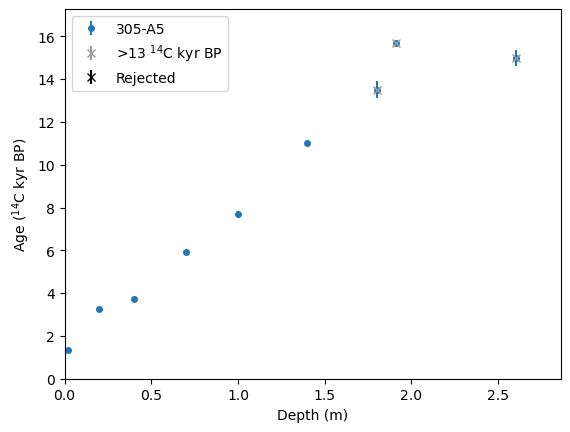

In [370]:
compiplot_grey(['305-A5'],[], dfall)

Core 305-A5 has a potential reversal near the bottom of the core but those ages are older than 13 14C ky BP hence we need not worry about how they might affect the apparent surface age calculation we will perform.

1.3363392857142848


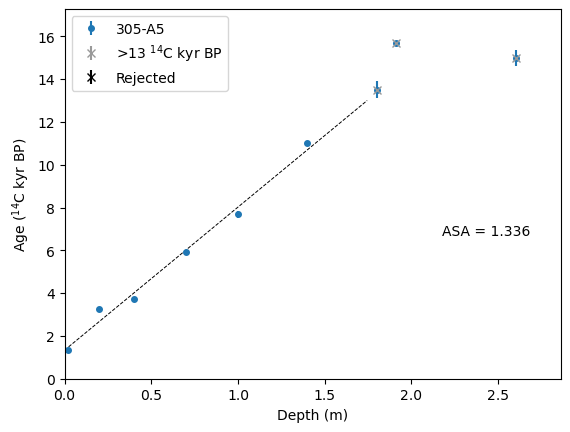

In [371]:
asa305 = ASA13_grey(['305-A5'], [], dfall)
print(asa305)

#### Core BSS06-G2

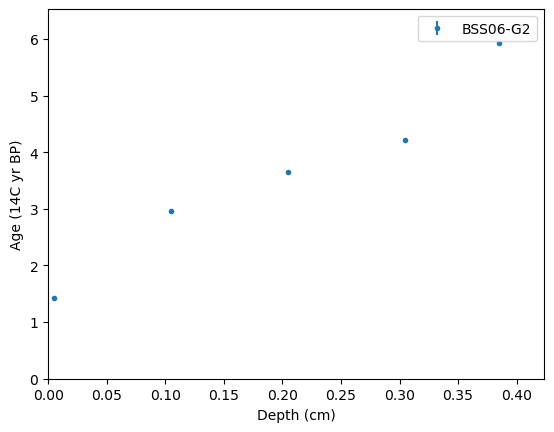

In [372]:
compiplot(['BSS06-G2'], [], dfall)

The data from BSS06-G2 looks relatively linear with no reversals, so we do not remove any ages.

1.4965866551126523


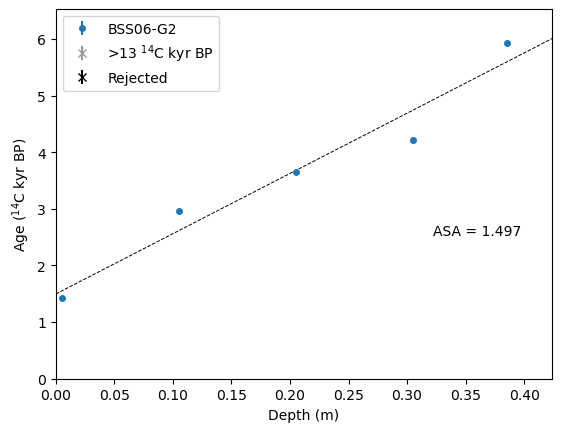

In [373]:
asaBSS06 = ASA13_grey(['BSS06-G2'],[], dfall)
print(asaBSS06)

#### Site 316

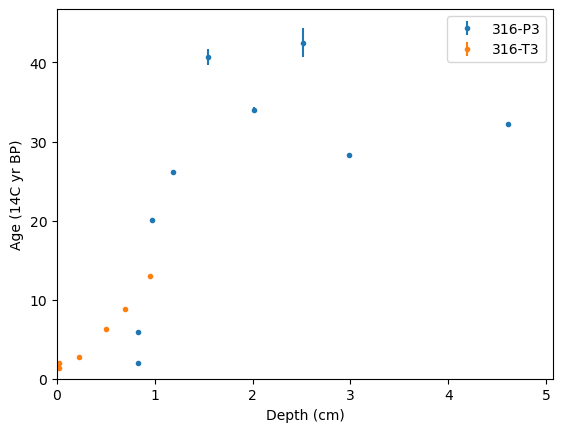

In [374]:
#Run through the '316-' cores data and plot them on a single plot
cores_316 = ['316-P3', '316-T3']
compiplot(cores_316, [], dfall)

It seems there is a clear linear sedimentation pattern suggested by 316-T3 but not by 316-P3. The youngest two ages in 316-P3 violate the law of superposition, hence we will reject them. The rest of the ages in 316-P3 are older tahn 13 14C ky BP, so they will not affect the analysis at all.

0.9213685334819361


/var/folders/4z/tw718w_s1wv0v2jmg91lbysh0000gn/T/ipykernel_46703/2051664044.py:208: UserWarning: The label '_nolegend_' of <ErrorbarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(legendl, loc=0)


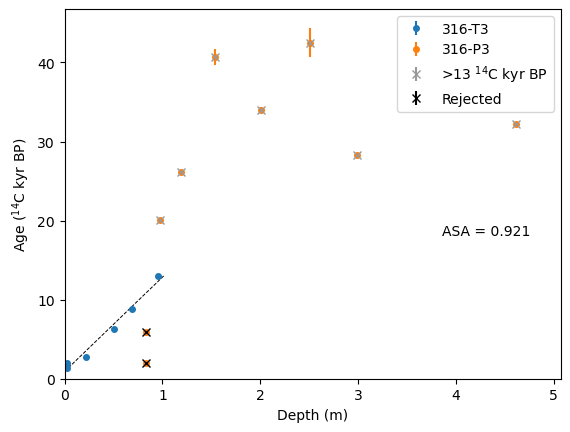

In [375]:
cores_316 = ['316-T3', '316-P3']

asa316 = ASA13_grey(cores_316, ['OS-00462','OS-00821'], dfall)
print(asa316)

#### Site 339

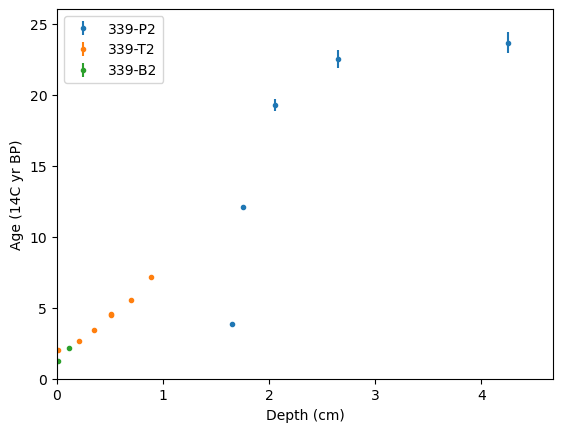

In [376]:
cores_339 = ['339-P2', '339-T2', '339-B2']

compiplot(cores_339, [], dfall)

The shallowest age in 339-P2 violates the rule of superposition so we reject it. It could be argued that all of the data from core 339-P2 should be removed, because it does not follow a linear pattern. However, after removing the shallowest age from 339-P2, the ages comply with the rule of superposition, and only the 2nd age, which looks to follow the linear pattern from core 339-T2, is young enough to be considered in our ASA estimation.

So, there are two options:
- Option 1 - Only reject shallowest age from 339-P2
- Option 2 - Reject all ages from 339-P2

Colman et al. (1996) performed their linear regression on this site following Option 1. They returned an intercept of 1.48 14C ky. Let us first follow Option 1.

/var/folders/4z/tw718w_s1wv0v2jmg91lbysh0000gn/T/ipykernel_46703/2051664044.py:208: UserWarning: The label '_nolegend_' of <ErrorbarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(legendl, loc=0)


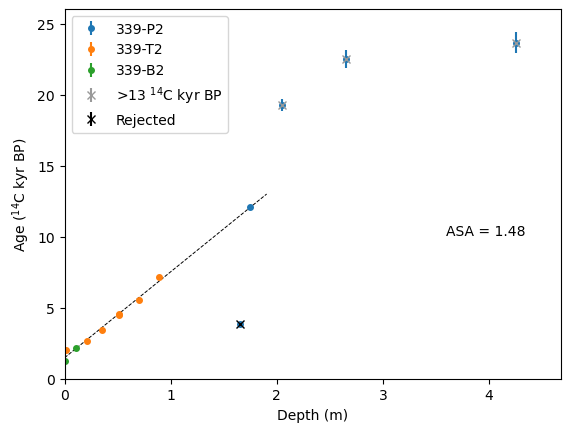

In [377]:
asa339 = ASA13_grey(cores_339,['CAMS-7572'], dfall)
#plt.savefig("ASAexample.png", dpi=300, bbox_inches="tight")

Our analysis confirms the reproducibility of the Colman et al. (1996) intercept value for this site.

Let us also try Option 2.

/var/folders/4z/tw718w_s1wv0v2jmg91lbysh0000gn/T/ipykernel_46703/2051664044.py:208: UserWarning: The label '_nolegend_' of <ErrorbarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(legendl, loc=0)


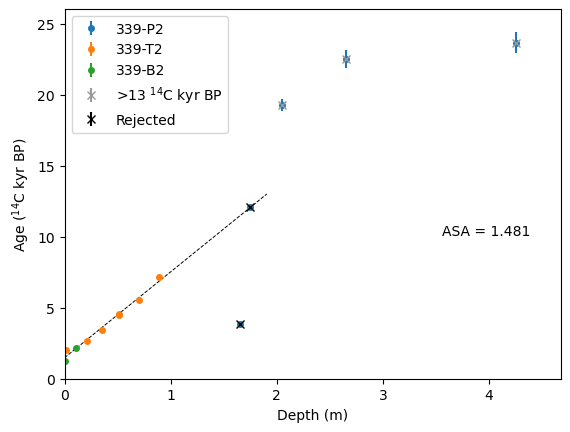

In [378]:
#Reject all dates fr

cores339b = ['339-T2', '339-B2']

asa339 = ASA13_grey(cores_339,['CAMS-7572', 'CAMS-8897'],dfall)

We find the intercept is still 1.48 14C ky BP, so we consider the two options equivalent. We will use the result produced by Option 2 going forward.

#### Core VER93-2 St.24GC

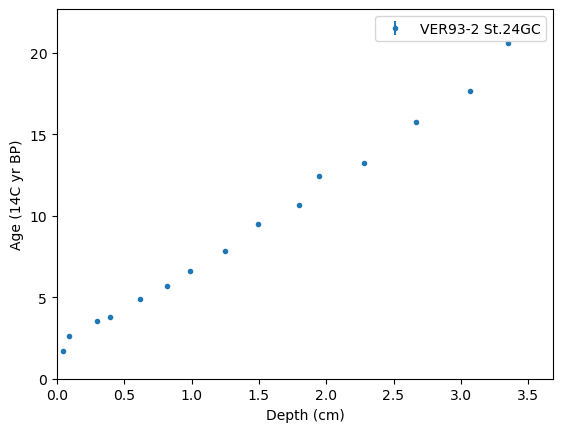

In [379]:
compiplot(['VER93-2 St.24GC'], [],dfall)

There are no ages that violate the law of superposition, so we will not exclude any ages.

For context, Karabanov et al. (2004) applied a linear regression to this core finding an intercept of 1588 14C ky BP, however they include all ages, whereas the method we use here - based on the method of Colman et al. (1996) - uses only ages younger than 13 14C ky BP.

First, however, let us attempt to reproduce the value of Karabanov et al. (2004) by applying an intercept method using all ages.

1.5692917837895841


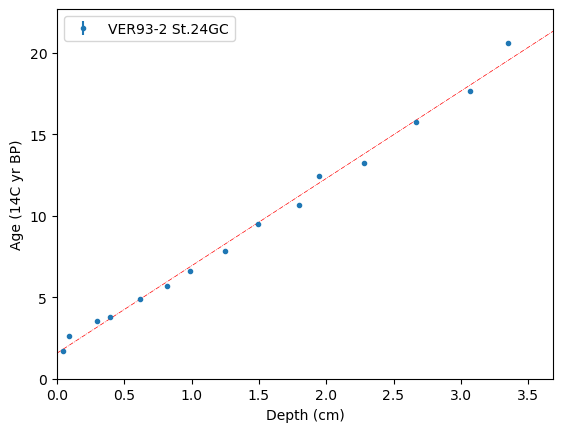

In [380]:
asaVER93 = ASAall(['VER93-2 St.24GC'], [],dfall)
print(asaVER93)

The intercept we return is very similar to but not the same as the intercept reported by Karabanov et al. (2004). One possibility is that the dates they reported in their Table 1 (which are the dates used here) were not corrected for isotopic fractionation, whereas the dates they actually performed their regression on where corrected for isotopic fractionation.

Regardless, let us move on to calculating the ASA using our intercept method.

1.7452540803716667


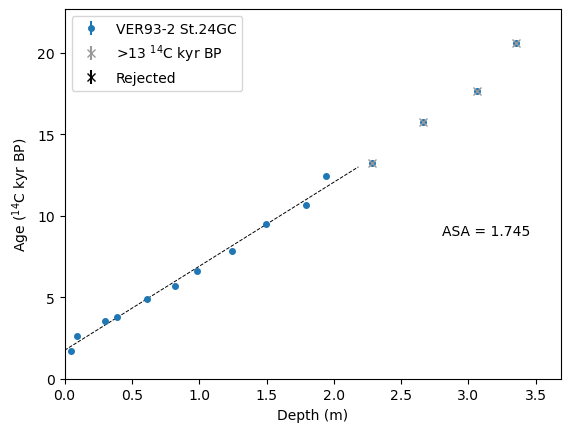

In [381]:
asaVER93 = ASA13_grey(['VER93-2 St.24GC'], [],dfall)
print(asaVER93)

#### Core VER99G12

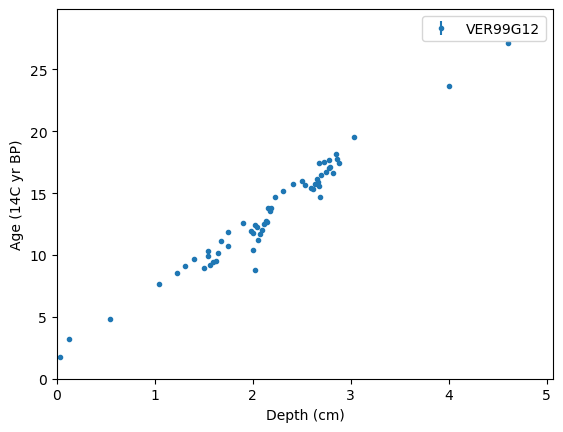

In [382]:
compiplot(['VER99G12'], [],dfall)

There is a clear linear pattern suggested by the dates but there are many dates that do not comply with the law of superposition. Below the date at 189.5cm (with an age of 12571 14C ky BP) there are a number of dates that look anomalously young. There are also a number of ages in the depth interval of 150-165cm that do not comply with the law of superposition - however it is not obvious which ages should be removed. 

We condsider 3 options here:
- Option 1 - Remove no dates
- Option 2 - Remove dates below the depth of 190cm
- Option 3 - Remove dates below the depth of 190cm AND remove the dates in the 150-165 cm range

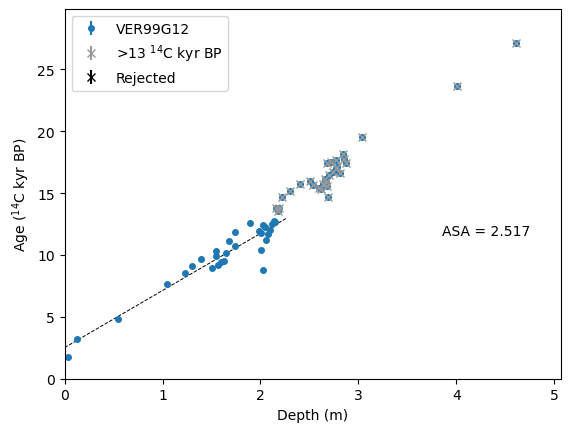

In [383]:
VER99_xcodes_opt1 = []
asaVER99_opt1 = ASA13_grey(['VER99G12'],VER99_xcodes_opt1,dfall)

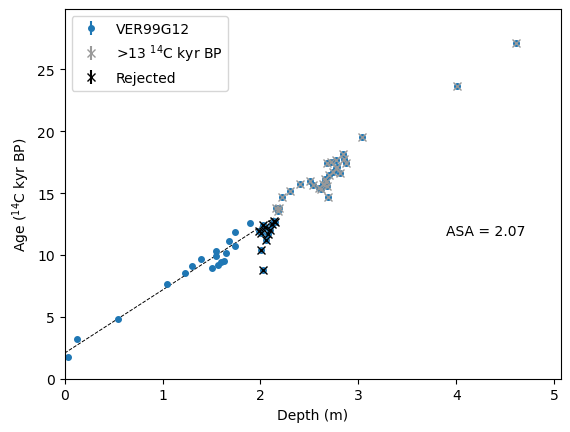

In [384]:
VER99_xcodes_opt2 = ['NUTA2-13986', 'NUTA2-13255','NUTA2-9603','NUTA-10717','NUTA2-13257','NUTA2-13989','NUTA2-9602', 'JAT-12144', 'JAT-12145', 'JAT-12146', 'JAT-12147', 'JAT-12148']
asaVER99_opt2 = ASA13_grey(['VER99G12'],VER99_xcodes_opt2,dfall)

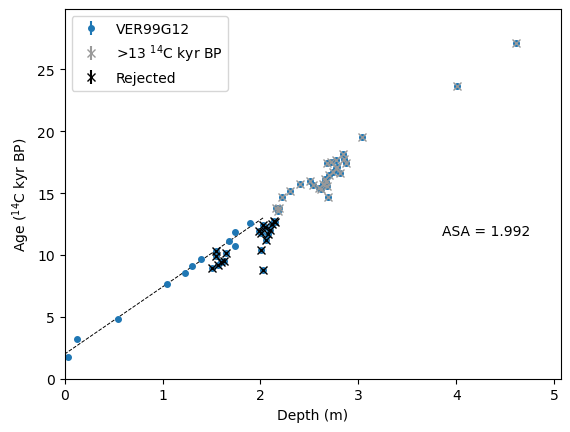

In [385]:
VER99_xcodes_opt3 = ['NUTA2-13986', 'NUTA2-13255','NUTA2-9603','NUTA-10717','NUTA2-13257','NUTA2-13989','NUTA2-9602', 'JAT-12144', 'JAT-12145', 'JAT-12146', 'JAT-12147', 'JAT-12148', 'NUTA2-13254', 'NUTA2-13991','NUTA2-8902', 'NUTA2-13992', 'NUTA2-10711', 'NUTA2-13993', 'NUTA2-9597']
asaVER99_opt3 = ASA13_grey(['VER99G12'],VER99_xcodes_opt3,dfall)

The ASA, if those dates were removed, would be slightly lower. It is worth noting that even within a core the choice of what ages to remove can introduce an uncertainty of 80 years.

#### BDP93



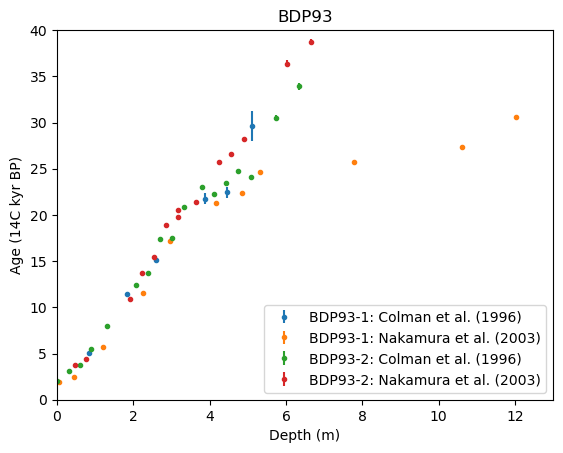

In [386]:
BDP93_cores = ['BDP93-1', 'BDP93-2']
compiplot_2ref(BDP93_cores,'Colman et al. (1996)','Nakamura et al. (2003)','BDP93',dfall)


Here we observe something that was noted by Colman et al. 1996. The BDP93-1 has some very deep sections that were analysed for radiocarbon, and we see that they suggest a much higher sedimentation rate than the deep analyses in BDP93-2. (Note, the data that Colman used to observe this are not actually in the figure above because they do not have associated age uncertainties and hence are discarded, however somewhat similar results are observed from the Nakamura et al. 2003 data.).

Colman et al. 1996 reported that this was due to the poor storage conditions of the BDP93-1 core, which was seen to have visible organic growth on the outside of the sample. It is possible therefore that the samples was contaminated by a small amount of modern carbon, which would have disproportionately affected the older samples. Colman et al. 1996 did not, however, reject all BDP93-1 radiocarbon analyses, only the older, visibly younger samples.

Deciding to reject some deeper samples from BDP93-1, but not the entire core, raises the question of what cutoff point should be used. Furthermore, should some greater uncertainty be assigned to the young BDP93-1 cores or not.

Let us, however, put off these queries for later enquiry, as the current task is to assess Colman et al. 1996's evaluation of the apparent surface age of the BDP93 core. Assuming we needn't discard all data from BDP93-1, and also that the cutoff point for which deeper samples to remove is significantly deep that it does not remove any data with ages younger than 13k, we can follow Colman's methodology below. First, we will perform the linear regression on the combined data from both cores as reported by Colman (test repeatability of Colman's results). Then, we shall perform it with Nakamura's data added too.

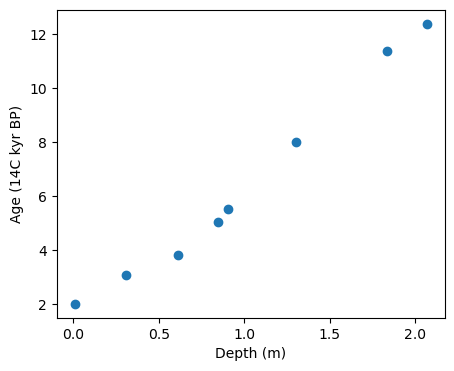

(1.1600656139834662, 5.320417813749099, 'y = 1.1600656139834662 + 5.32x')

In [387]:
#We do not use the ASA13 function here, because it doesn't have the functionality to select only the Nakamura data.

#Set up empty vectors to store the important info
xBDP93C = pd.Series([], dtype='int32')
yBDP93C = pd.Series([], dtype='int32')

BDP93_cores = ['BDP93-1', 'BDP93-2']
core_names = BDP93_cores
ref1 = 'Colman et al. (1996)'
ref2 = 'Nakamura et al. (2003)'
for core in core_names:
    # subset to this core
    rdata = dfall[dfall['Core Name'] == core].copy()
    if rdata.empty:
        continue

    # TOC only
    rd_toc = rdata[rdata['Material'] == 'TOC'].copy()
    if rd_toc.empty:
        continue

    # keep only rows with numeric error
    rd_toc = rd_toc[rd_toc['Error'].notna()].copy()
    if rd_toc.empty:
        continue

    # split by reference
    rd_tocr1 = rd_toc[rd_toc['Reference'] == ref1].copy()

        
    rd_tocr113 = rd_tocr1[rd_tocr1['Value'] < 13]

    # choose depth column: prefer corrected if any numeric values exist
    use_corrected_r1 = rd_tocr113['Corrected Depth'].notna().any()
    if use_corrected_r1:
        xr1 = rd_tocr113['Corrected Depth']
    else:
        xr1 = rd_tocr113['Middle Depth']

    # ages and errors
    yr1 = rd_tocr113['Value']
    yerrorr1 = rd_tocr113['Error']
    
    xBDP93C = pd.concat([xBDP93C, xr1])
    yBDP93C = pd.concat([yBDP93C, yr1])
    
plt.figure(figsize=(5,4))
plt.scatter(xBDP93C, yBDP93C)
plt.xlabel("Depth (m)")
plt.ylabel("Age (14C kyr BP)")
plt.show()
    
linear_regression(xBDP93C, yBDP93C)

We do indeed find Colman's value of 1.16 14C kyr repeatable, with his data.

What about with the newer Nakamura et al. 2003 data included?

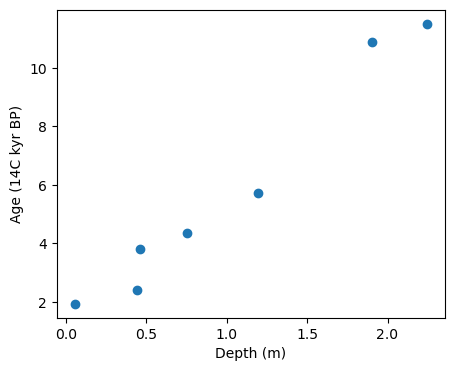

(1.0556469822175814, 4.712783722915612, 'y = 1.0556469822175814 + 4.713x')

In [388]:
#We do not use the ASA13 function here, because it doesn't have the functionality to select only the Nakamura data.

#Set up empty vectors to store the important info
xBDP93C = pd.Series([], dtype='int32')
yBDP93C = pd.Series([], dtype='int32')

BDP93_cores = ['BDP93-1', 'BDP93-2']
core_names = BDP93_cores
ref1 = 'Colman et al. (1996)'
ref2 = 'Nakamura et al. (2003)'
for core in core_names:
    # subset to this core
    rdata = dfall[dfall['Core Name'] == core].copy()
    if rdata.empty:
        continue

    # TOC only
    rd_toc = rdata[rdata['Material'] == 'TOC'].copy()
    if rd_toc.empty:
        continue

    # keep only rows with numeric error
    rd_toc = rd_toc[rd_toc['Error'].notna()].copy()
    if rd_toc.empty:
        continue

    # split by reference
    rd_tocr1 = rd_toc[rd_toc['Reference'] == ref2].copy()

        
    rd_tocr113 = rd_tocr1[rd_tocr1['Value'] < 13]

    # choose depth column: prefer corrected if any numeric values exist
    use_corrected_r1 = rd_tocr113['Corrected Depth'].notna().any()
    if use_corrected_r1:
        xr1 = rd_tocr113['Corrected Depth']
    else:
        xr1 = rd_tocr113['Middle Depth']

    # ages and errors
    yr1 = rd_tocr113['Value']
    yerrorr1 = rd_tocr113['Error']
    
    xBDP93C = pd.concat([xBDP93C, xr1])
    yBDP93C = pd.concat([yBDP93C, yr1])
    
plt.figure(figsize=(5,4))
plt.scatter(xBDP93C, yBDP93C)
plt.xlabel("Depth (m)")
plt.ylabel("Age (14C kyr BP)")
plt.show()
    
linear_regression(xBDP93C, yBDP93C)

The intercept is 1056 14C yr BP. So whilst the Colman et al. (1996) intercept is reproducible, it is not repeatable with the dates provided by Nakamura et al. (2003).

Let us look at the intercept using data from both cores and both references.

/var/folders/4z/tw718w_s1wv0v2jmg91lbysh0000gn/T/ipykernel_46703/2051664044.py:208: UserWarning: The label '_nolegend_' of <ErrorbarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(legendl, loc=0)


1.1511632920253394

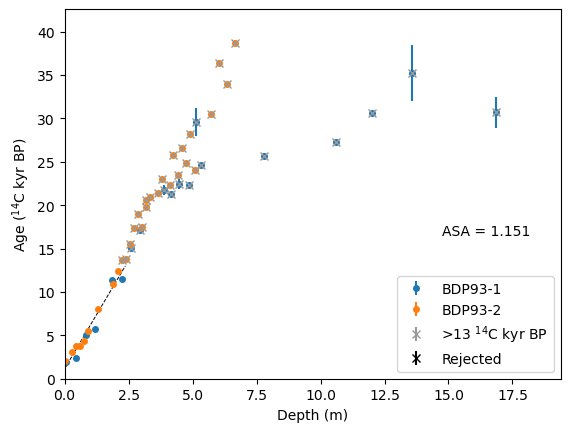

In [389]:
ASA13_grey(BDP93_cores,[],dfall)

We find the result is quite simlar to the Colman et al. (1996) result.

Knowing about the contamination seen in BDP93-1, we are interested to see if there is any significant difference between the apparent surface age of BDP93-1 and BDP93-2.

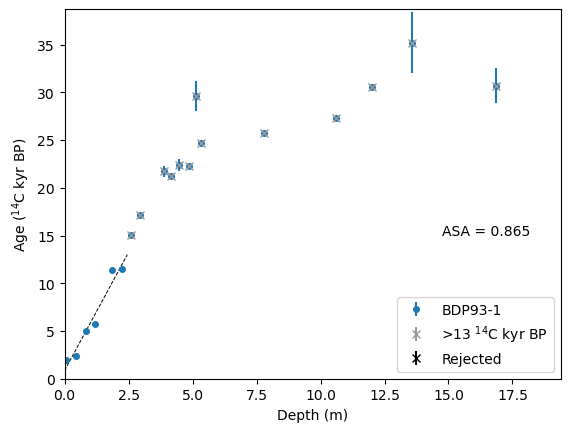

In [390]:
asaBDP931 = ASA13_grey(['BDP93-1'],[], dfall)


The apparent surface age for core BDP93-1 is 0.8654238866024748 14C y BP
The apparent surface age for core BDP93-2 is 1.25726815513858 14C y BP


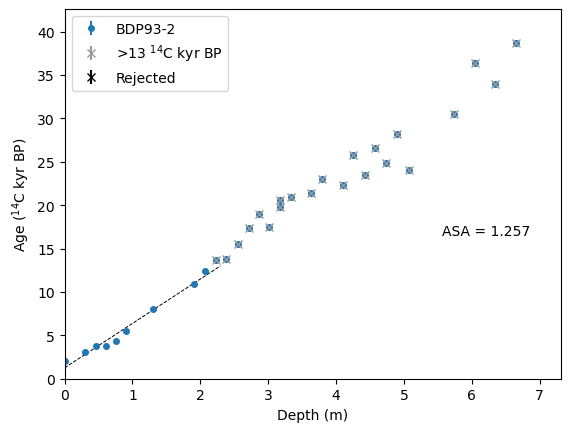

In [391]:
asaBDP932 = ASA13_grey(['BDP93-2'],[], dfall)
print('The apparent surface age for core BDP93-1 is ' + str(asaBDP931) + ' 14C y BP')
print('The apparent surface age for core BDP93-2 is ' + str(asaBDP932) + ' 14C y BP')

The difference in apparent surface age is approximately 400 14C y. Based on the knowledge of the contamination of BDP93-1, we believe a better approximation of the apparent surface age for this core would be 1.26 14C ky BP, not the 1.16 suggested by Colman et al. 1996.

#### Buguldeika Saddle Results

In the whole of the Buguldeika Saddle, there are 7 ASA estimates.

In [393]:
BS_asas = [asa305, asa316, asa339, asaBDP932, asaVER99_opt3, asaVER93, asaBSS06]
mBS = sum(BS_asas)/len(BS_asas)
rBS = max(BS_asas)-min(BS_asas)
varBS = sum((BS_asas - mBS) ** 2) / len(BS_asas)
stdBS = math.sqrt(varBS)

print([BS_asas])
print('The min and max apparent surface ages of the cores at Buguldeika Saddle are '+ str(round(min(BS_asas), 3))+' and '+ str(round(max(BS_asas),3))+' 14C ky BP respectively')

print('The ASAs at Buguldeika Saddle have a mean and standard deviation of '+ str(round(mBS,3))+' ± ' + str(round(stdBS,3)) +  ' 14C ky BP, as calculated from ' + str(len(BS_asas))+ ' cores.')


[[1.3363392857142848, 0.9213685334819361, 1.481181468787197, 1.25726815513858, 1.992404130925797, 1.7452540803716667, 1.4965866551126523]]
The min and max apparent surface ages of the cores at Buguldeika Saddle are 0.921 and 1.992 14C ky BP respectively
The ASAs at Buguldeika Saddle have a mean and standard deviation of 1.461 ± 0.319 14C ky BP, as calculated from 7 cores.


If we look only at the cluster of cores that are very close to each other, there are just 4 ASA estimates.

In [308]:
BScluster_asas = (asaVER99_opt3, asaVER93, asaBDP932, asa339)
BScluster_asamean = sum(BScluster_asas)/len(BScluster_asas)
BScluster_range = max(BScluster_asas) - min(BScluster_asas)
BScluster_variance = sum((BScluster_asas - BScluster_asamean) ** 2) / len(BScluster_asas)
BScluster_std = math.sqrt(BScluster_variance)
BScluster_uncertainty = BScluster_range/2

print('The age offset at North Buguldeika Saddle is estimated to be ' + str(round(BScluster_asamean,3)) + ' ± ' + str(round(BScluster_std,3)) + ' 14C ky BP')

The age offset at North Buguldeika Saddle is estimated to be 1.619 ± 0.276 14C ky BP


### Academician Ridge

#### Site 18

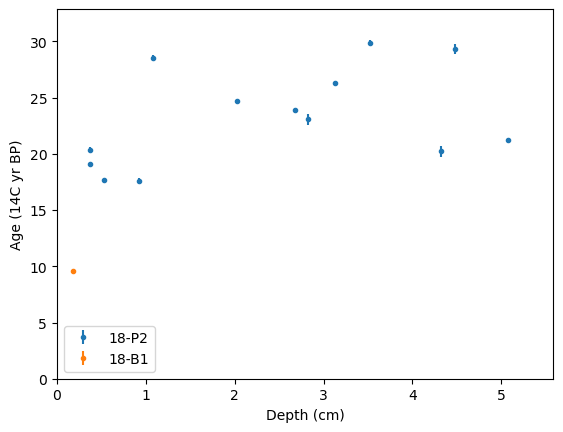

In [309]:
#Run through the '18-' cores data and plot them on a single plot
cores_18 = ['18-P2', '18-B1']
compiplot(cores_18, [],dfall)

The plot of site 18 tells us we cannot expect any linear pattern to be revealed from this data. There is only 1 age younger than 13 14C ky BP, so we do not calculate any ASA here.

#### Site 333

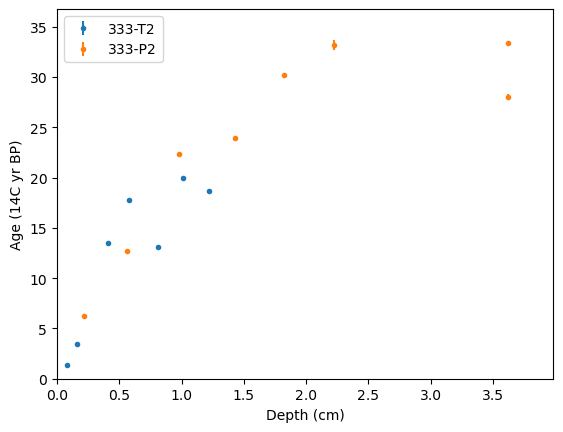

In [310]:
#Run through the '333-' cores data and plot them on a single plot
cores_333 = ['333-T2', '333-P2']
compiplot(cores_333, [],dfall)

There are a number of difficult ages here, between the depths of around 50 to 150cm, however these ages are all older than 13 14C ky BP, so we can simply perform the ASA analysis.

0.07737864077669965


/var/folders/4z/tw718w_s1wv0v2jmg91lbysh0000gn/T/ipykernel_46703/2051664044.py:208: UserWarning: The label '_nolegend_' of <ErrorbarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(legendl, loc=0)


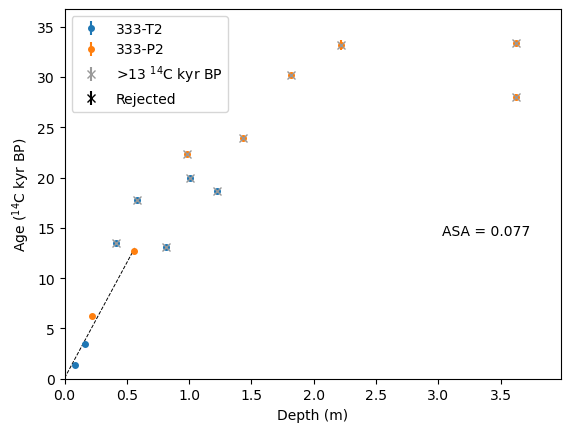

In [311]:
asa333 = ASA13_grey(cores_333, [],dfall)
print(asa333)

#### Site 340

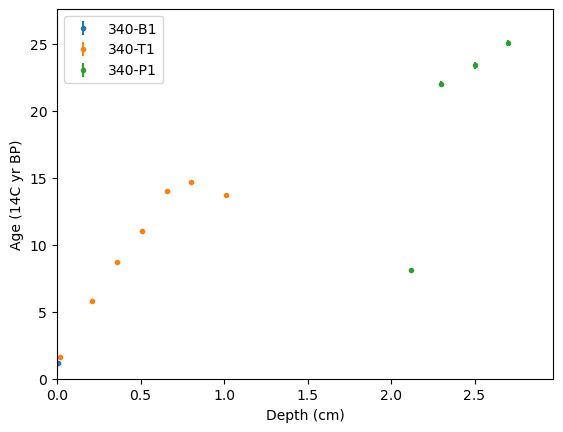

In [312]:
#Run through the '340-' cores data and plot them on a single plot
cores_340 = ['340-B1', '340-T1', '340-P1']

compiplot(cores_340, [],dfall)

There is a clear reversal at the deep end of 340-T1, but this is older than 13 14C ky BP so we need not address it. There is a problematic age seen in 340-P1, which we remove.

/var/folders/4z/tw718w_s1wv0v2jmg91lbysh0000gn/T/ipykernel_46703/2051664044.py:208: UserWarning: The label '_nolegend_' of <ErrorbarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(legendl, loc=0)


1.2816840332596584


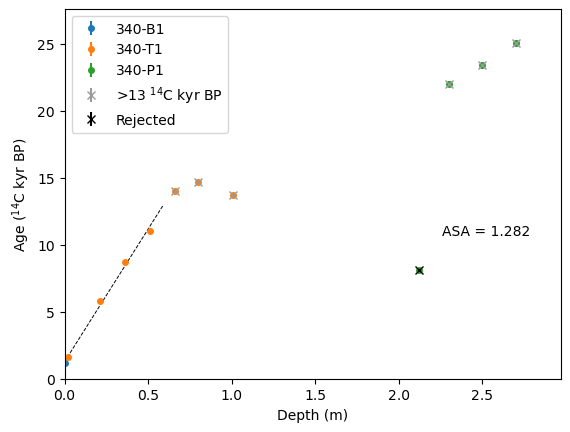

In [313]:
#Note the lab codes of data to remove
xlabcodes_340 = ['CAMS-8891']

asa340 = ASA13_grey(cores_340, xlabcodes_340,dfall)
print(asa340)

#### Site 307

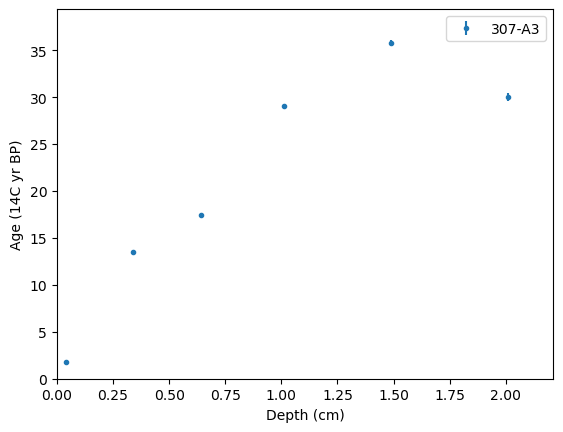

In [314]:
compiplot(['307-A3'], [],dfall)

There is not enough data younger than 13 14C ky BP to perform our linear regression analysis here.

#### Site 331

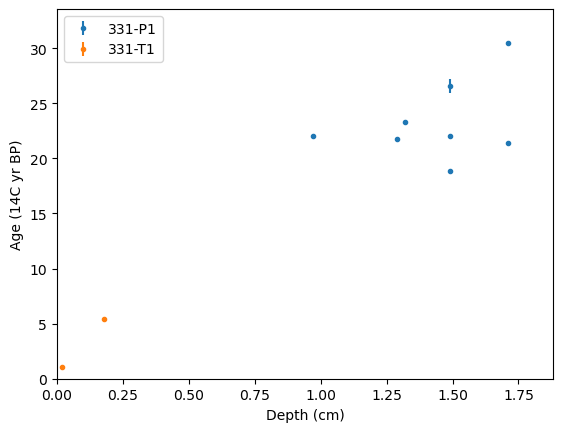

In [315]:
cores_331 = ['331-P1','331-T1']
compiplot(cores_331, [],dfall)

There are many age reversals in the data for core 331-P1. The data should be treated with caution. With caution in mind, the two options here seem to be 1) ignoring all data from 331-P1, or 2) retaining only the shallowest age, as it looks to continue linearly from the data of 331-T1. It doesn't actually matter for calculating the apparent surface age following our methodology however.

0.5462500000000006


/var/folders/4z/tw718w_s1wv0v2jmg91lbysh0000gn/T/ipykernel_46703/2051664044.py:208: UserWarning: The label '_nolegend_' of <ErrorbarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(legendl, loc=0)


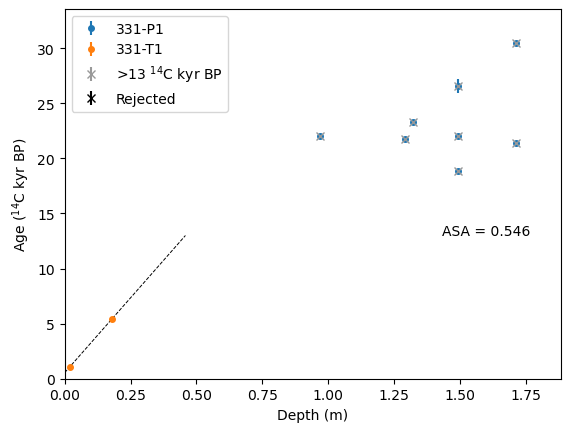

In [316]:
asa331 = ASA13_grey(cores_331, [],dfall)
print(asa331)

#### Site VER98st5

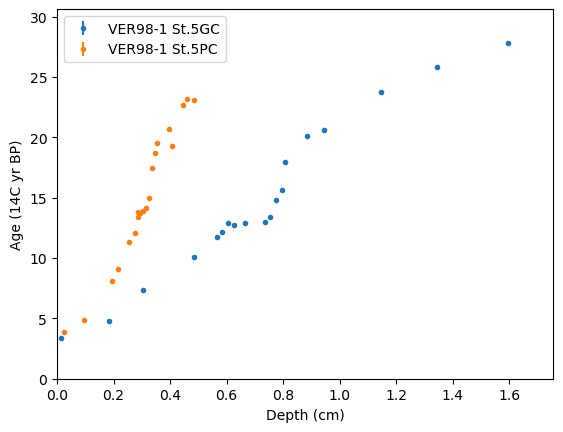

In [317]:
cores_VER98st5 = ['VER98-1 St.5GC','VER98-1 St.5PC']
compiplot(cores_VER98st5, [],dfall)

The two cores at this site show extremely different sedimentation rates, the reason for which is not clear. They do, however, both show a generally similar overall pattern, specifically in the centre of the cores, in which around 13-15 14C ky BP there seems to have been a markedly greater sedimentation rate. Watanabe et al. (2009) have interpreted this to be a result of the atmospheric 14C fluctuation that happened at the time of the Younger Dryas. They note an approximate similarity with the other core they investigate, VER98-1 St.6GC.

Watanabe et al. (2009) suggest that VER98-1 St.5PC suffered from compression.

Because of their different sedimentation rates, we will have to perform their linear regressions separately.

2.5387049382716045


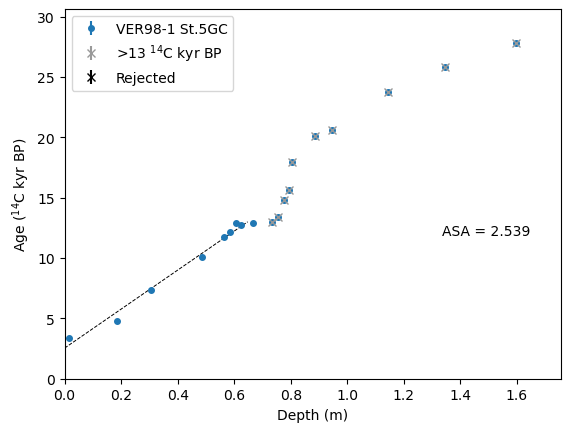

In [318]:
asaVER98st5GC = ASA13_grey(['VER98-1 St.5GC'], [],dfall)
print(asaVER98st5GC)

2.281383503701095


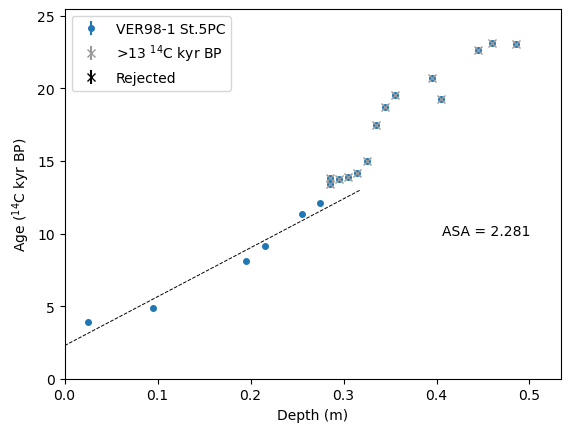

In [319]:
asaVER98st5PC = ASA13_grey(['VER98-1 St.5PC'], [],dfall)
print(asaVER98st5PC)

#### Site VER98st6

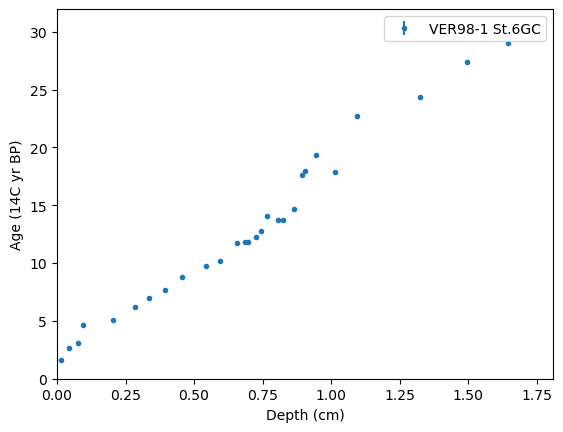

In [320]:
cores_VER98st6 = ['VER98-1 St.6GC']
compiplot(cores_VER98st6,[],dfall)

2.1718970892853946


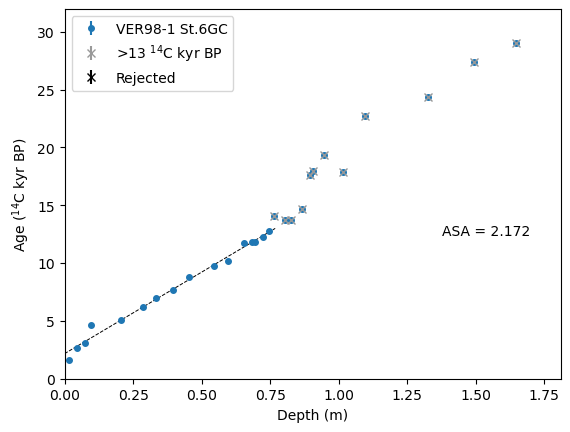

In [321]:
asaVER98st6 = ASA13_grey(cores_VER98st6, [],dfall)
print(asaVER98st6)


#### Site VER93-2 st.4-PC

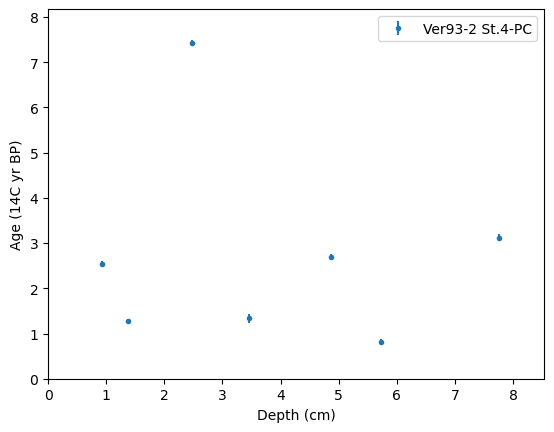

In [326]:
cores_VER93st4 = ['Ver93-2 St.4-PC']
compiplot(cores_VER93st4,[],dfall)

There is clearly no linear trend that might be fashioned by removing a few anomalies for core Ver93-2 st.4-PC, hence we suggest that linear regression on this core would be unwise.

#### Site VER94st16

Site VER94 St16 is a somewhat complicated situation. Horiuchi et al. (2001) reports a core, VER94/st.16. It turns out it's actually a composite record of the following cores:
* Ver94-5 St.16-Pilot;
* A surface sample by a Smith-Mcintyre sediment sampler (Lab Code = NUTA-4152);

but, it leaves out data from neighbouring core Ver94-5 St.16-PC, which is reported by Nakamura et al. (2003). The addition of a date from a surface sampler, in the context of this paper, would be inconsistent with the fact that all other dates have come from sediment cores, not surface samplers. Hence, we do not incorporate the date from the surface sampler and we will not continue to use the core name VER94 st.16, but instead refer to the two cores Ver94-5 St.16-Pilot and Ver94-5 St.16-PC which are at the site VER94st16

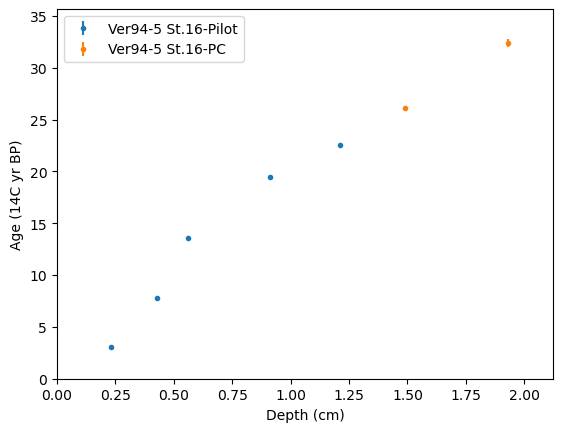

In [327]:
cores_VER94st16 = ['Ver94-5 St.16-Pilot','Ver94-5 St.16-PC']
compiplot(cores_VER94st16, [],dfall)

-2.4885


/var/folders/4z/tw718w_s1wv0v2jmg91lbysh0000gn/T/ipykernel_46703/2051664044.py:208: UserWarning: The label '_nolegend_' of <ErrorbarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(legendl, loc=0)


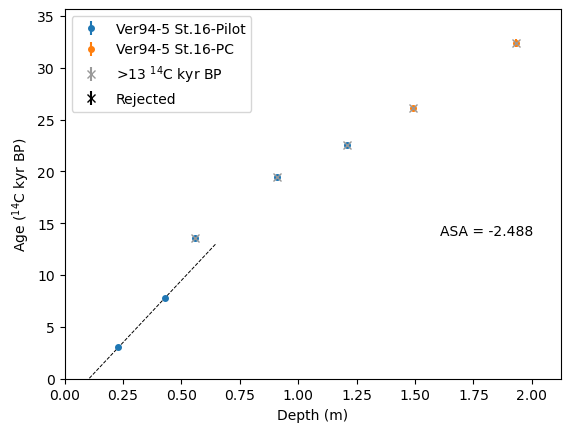

In [328]:
asaVER94st16 = ASA13_grey(cores_VER94st16,[],dfall)
print(asaVER94st16)

#### Site VER94-5 St.19

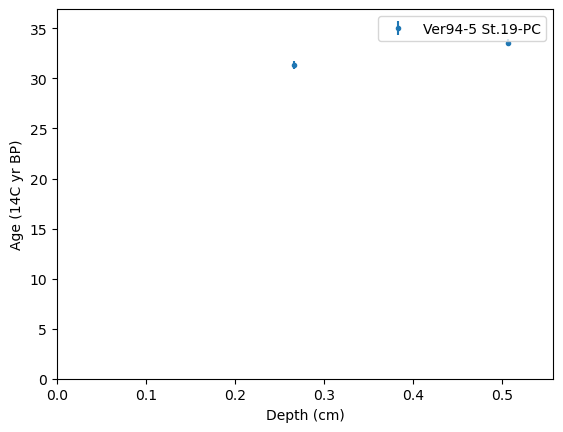

In [330]:
cores_Ver94st19 = ['Ver94-5 St.19-PC']
compiplot(cores_Ver94st19,[],dfall)

There are no ages younger than 13 14C ky BP, hence we cannot perform our method of linear regression here.

#### Site VER96st3

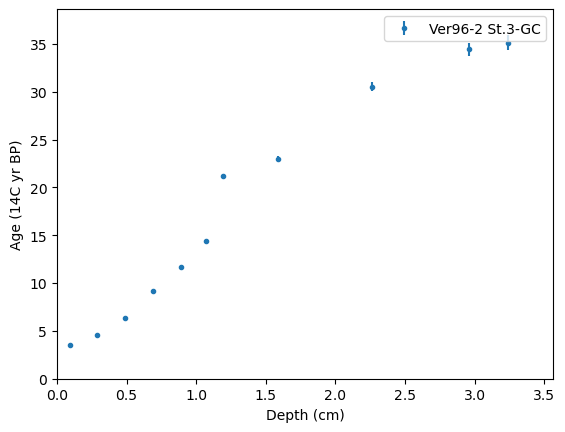

In [331]:
cores_Ver96st3 = ['Ver96-2 St.3-GC']
compiplot(cores_Ver96st3,[],dfall)

1.9421999999999997


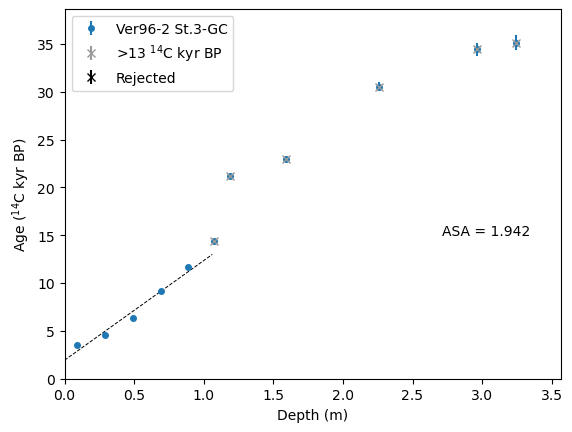

In [332]:
asaVer96st3 = ASA13_grey(cores_Ver96st3, [],dfall)
print(asaVer96st3)

The partial non-linearity of the ages younger than 13 14C ky BP suggests that maybe the apparent surface age should actually be somewhat higher than that returned using our method, however for consistency we will keep the estimation made above.

#### Site VER96st7

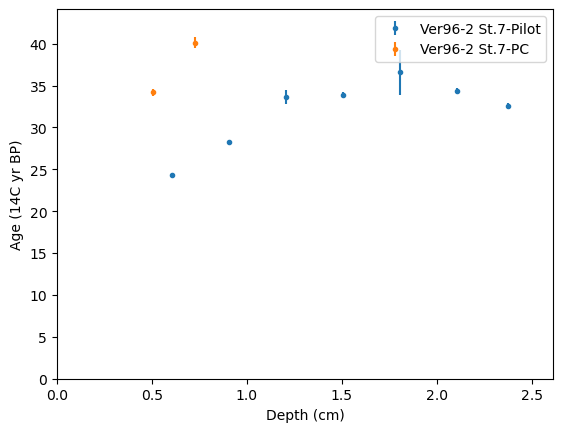

In [333]:
cores_Ver96st7 = ['Ver96-2 St.7-Pilot','Ver96-2 St.7-PC']
compiplot(cores_Ver96st7, [],dfall)

In [334]:
ASA13_grey(cores_Ver96st7, [],dfall)

'Not enough data younger than 13 14C ky BP to perform linear regression'

#### Site Ver97st6

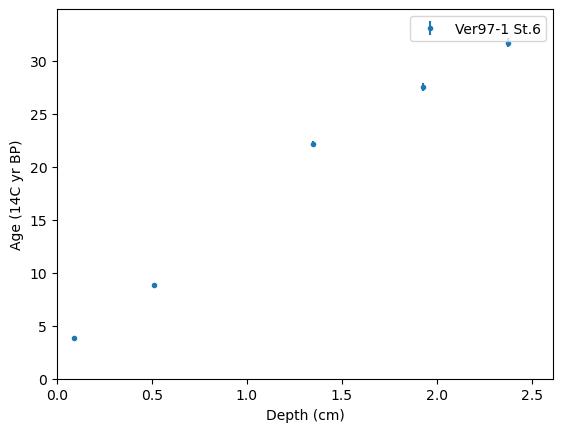

In [335]:
compiplot(['Ver97-1 St.6'], [],dfall)

2.77383787661406


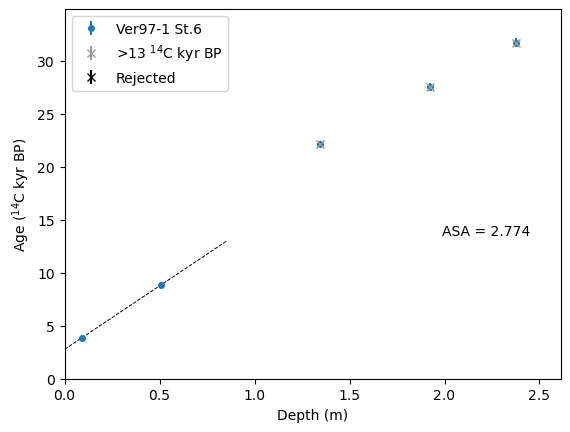

In [336]:
asaVer97st6 = ASA13_grey(['Ver97-1 St.6'], [],dfall)
print(asaVer97st6)

#### BDP98

2.8596666666666684


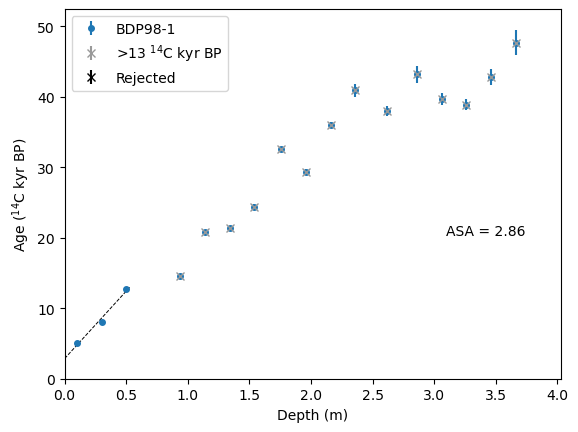

In [337]:
asaBDP98 = ASA13_grey(['BDP98-1'], [],dfall)
print(asaBDP98)

#### Academician Ridge Overview

We've looked at all the sites within Academician Ridge now and found

* Site 18 yields no reasonable linear pattern
* Site 333 with 4 ages <13 14C ky BP, yields an ASA of 0.08 14C ky BP.
* Site 340 with 5 ages <13 14C ky BP, yields an ASA of 1.28 14C ky BP.
* Site 307 has only 1 age <13 14C ky BP so we cannot apply the method.
* Site 331 with 2 ages <13 14C ky BP, yields an ASA of 0.55 14C ky BP.
* Core Ver98-1 St.5GC with 9 ages <13 14C ky BP yields an ASA of 2.54 14C ky BP
* Core Ver98-1 St.5PC with 6 ages <13 14C ky BP yields an ASA of 2.28 14C ky BP
* Core VER98-1 St.6GC with 16 ages <13 14C ky BP yields an ASA of 2.17 14C ky BP
* Core VER93-2 St.4-PC yields no reasonable linear pattern
* Site Ver94st16 with 2 ages <13 14C ky BP, yields an ASA of -2.49 14C ky BP
* Core Ver94-5 st.19-PC does not have any ages <13 14C ky BP upon which to apply the method
* Core Ver96-2 St.3-GC with 5 ages <13 14C ky BP yields an ASA of 1.94 14C ky BP
* Site Ver96st7 does not have any any ages <13 14C ky BP upon which to apply the method
* Core Ver97-1 St.6 with 2 ages <13 14C ky BP yields an ASA of 2.77 14C ky BP
* Core BDP98 with 3 ages <13 14C ky BP yields an ASA of 2.86 14C ky BP

Therefore, the only reasonable sites whose answers to look at are:
   * Site 333              (ASA = 0.08 14C ky BP)
   * Site 340              (ASA = 1.28 14C ky BP)
   * Core Ver98-1 St.5GC   (ASA = 2.54 14C ky BP)
   * Core Ver98-1 St.5PC   (ASA = 2.28 14C ky BP)
   * Core Ver98-1 St.6GC   (ASA = 2.17 14C ky BP)
   * Core Ver96-2 St.3-GC  (ASA = 1.94 14C ky BP)
   * Core Ver97-1 St.6     (ASA = 2.77 14C ky BP)
   * Core BDP9             (ASA = 2.86 14C ky BP)
   
 Comment : One might decide to treat site 333 as an outlier, with such a low ASA but we will continue without doing so.

In [338]:
AR_asas = [asaVER98st6, asaVER98st5GC, asa331, asa340, asa333, asaVer96st3, asaVer97st6, asaBDP98]
AR_asamean = sum(AR_asas)/len(AR_asas)
AR_asarange = max(AR_asas) - min(AR_asas)
AR_asavariance = sum((AR_asas - AR_asamean)**2 / len(AR_asas))
AR_asastd = math.sqrt(AR_asavariance)
print('The apparent surface age at Academician Ridge is '+ str(round(AR_asamean, 3))+' ± ' +str(round(AR_asastd, 3))+' 14C ky BP, as calculated from ' + str(len(AR_asas))+ ' cores.')

print('The min and max apparent surface ages of the cores considered are '+ str(round(min(AR_asas),3))+' and '+ str(round(max(AR_asas),3))+' 14C ky BP respectively')

The apparent surface age at Academician Ridge is 1.774 ± 0.973 14C ky BP, as calculated from 8 cores.
The min and max apparent surface ages of the cores considered are 0.077 and 2.86 14C ky BP respectively


### Other Locations

#### Maloe More
Maloe More has 4 cores. One at site 287 and three at site 342.

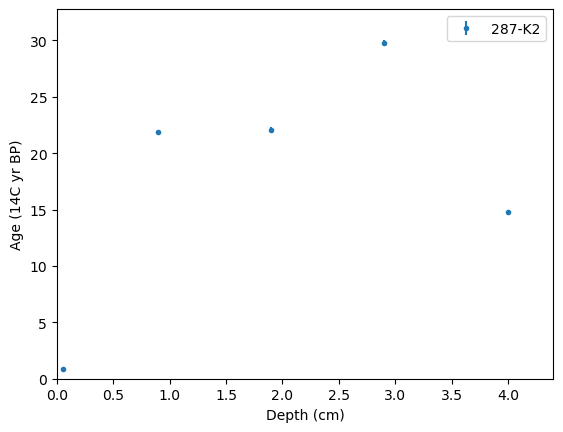

In [339]:
compiplot(['287-K2'],[],dfall)

In [340]:
ASA13_grey(['287-K2'],[],dfall)

'Not enough data younger than 13 14C ky BP to perform linear regression'

There is not enough data to perform a linear regression for core 287-K2.

Next we look at site 342.

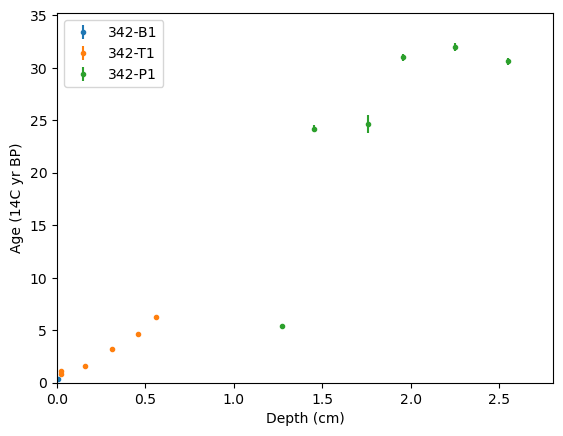

In [341]:
cores_342 = ['342-B1', '342-T1', '342-P1']
compiplot(cores_342,[],dfall)

Looking at the plot above, we see the shallowest age from 342-P1, with Lab Code CAMS-7584, violates the law of superposition so we remove that for the linear regression.

0.5006156300939004


/var/folders/4z/tw718w_s1wv0v2jmg91lbysh0000gn/T/ipykernel_46703/2051664044.py:208: UserWarning: The label '_nolegend_' of <ErrorbarContainer object of 3 artists> starts with '_'. It is thus excluded from the legend.
  plt.legend(legendl, loc=0)


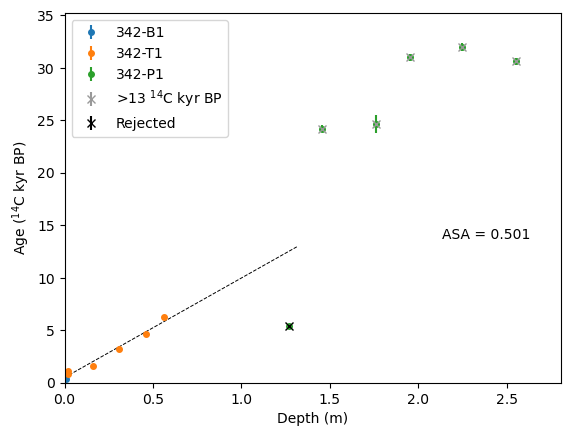

In [342]:
asa342 = ASA13_grey(cores_342,['CAMS-7584'],dfall)
print(asa342)

#### Continent Ridge

Continent Ridge is a bathymetric high north east of Academician Ridge. The only core with radiocarbon dates from this area is core CON01-603-5.

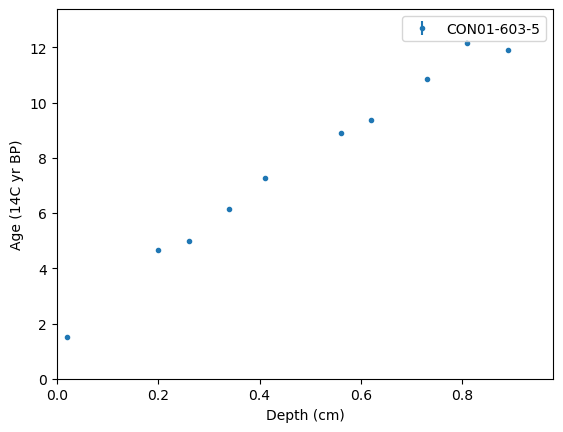

In [343]:
CR_cores = ['CON01-603-5']
compiplot(CR_cores,[],dfall)

The TOC dates from core CON01-603-5 shows a linear sedimentation profile for dates across the last 13,000 14C y BP. The only likely anomalies would be either of the oldest two dates in this portion of the core which show a reversal. Either of them could be the anomaly, however, so we could either remove one of these, or leave both. Let's look at all options.

1.8932000439415582


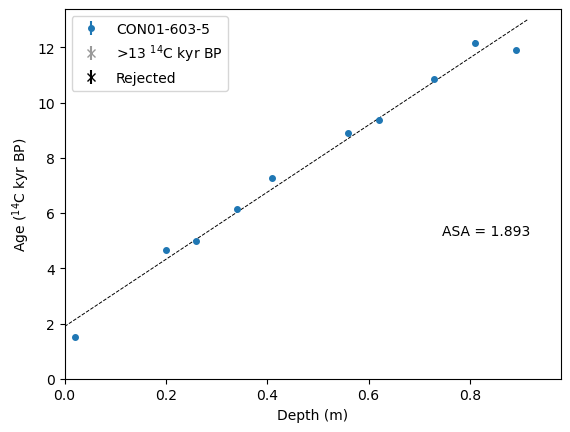

In [344]:
#Removing neither
asaCRtoc1 = ASA13_grey(CR_cores, [],dfall)
print(asaCRtoc1)

1.8932000439415582


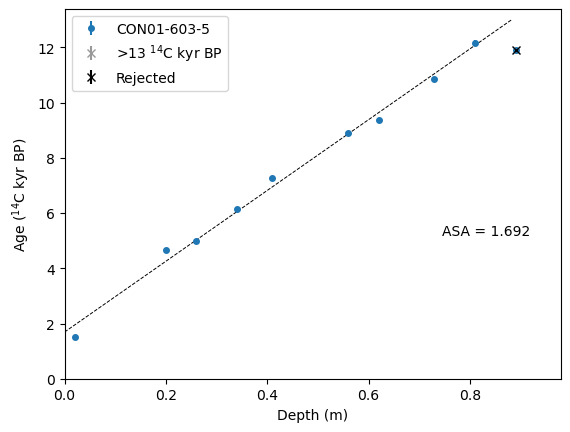

In [345]:
#Removing GdA-1379
asaCRtoc2 = ASA13_grey(CR_cores, ['GdA-1379'],dfall)
print(asaCRtoc1)

1.6924546455216287


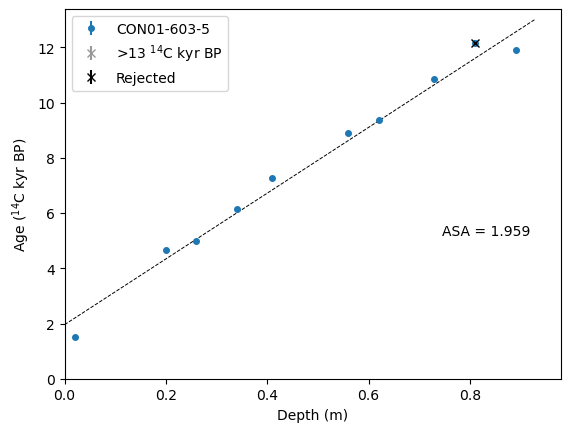

In [346]:
#Removing GdA-1378
asaCRtoc3 = ASA13_grey(CR_cores, ['GdA-1378'],dfall)
print(asaCRtoc2)

There is a range of ASAs resulting from these different options, from 1692 to 1893 to 1959 14C y BP. This highlights that this method of calculating the apparent surface age is not objective and that any resulting ASA should be taken with some uncertainty when being used as an age offset.

We will use the result where we removed neither as our ASA estimate for this location.

#### Posolskoe Bank

Posolskoe Bank is an isolated bathymetric high south-west of Buguldeika Saddle. The two cores from this area are Ver.99 G-6 and CON01-606-3. Only core Ver.99 G-6 has TOC dates.

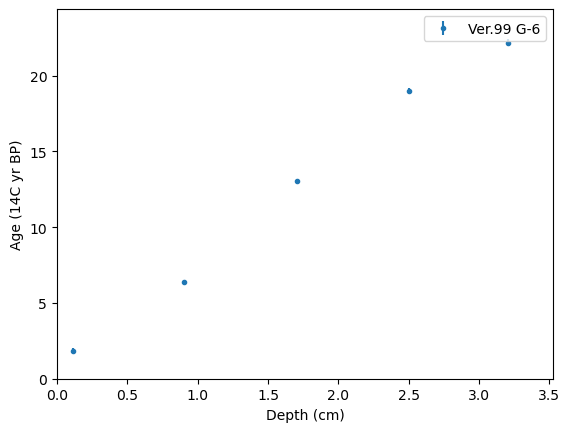

In [347]:
compiplot(['Ver.99 G-6'],[],dfall)

1.1921518987341773


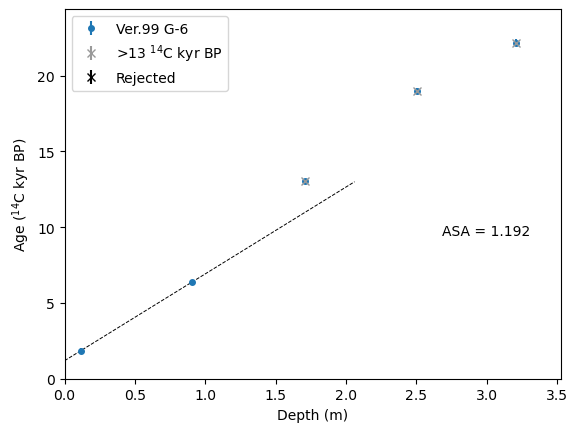

In [348]:
asaPBtoc = ASA13_grey(['Ver.99 G-6'],[],dfall)
print(asaPBtoc)

Only two of the ages from core Ver.99 G-6 are younger than 13 14C ky BP. Note, Tani et al., (2002) suggests that this core is missing 10cm from the top of the core, by comparing the core with another core Ver.99 M-6 which was taken in tandem. If true, this would make the actual apparent surface age a few hundred 14C y lower than the 1765 14C y BP value returned with our method, but it would still be greater than 1000 14C y BP.

#### Vydrino Shoulder

Vydrino Shoulder is another isolated bathymetric high in the southern region of the South Basin, with two cores, CON01-605-3 and CON01-605-5, which are from the same site so are considered together.

In [349]:
VS_cores = ['CON01-605-3','CON01-605-5']
#checkmat(VS_cores)

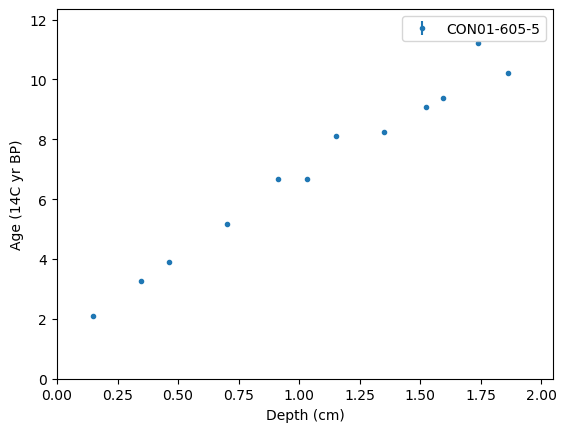

In [350]:
compiplot(['CON01-605-5'],[],dfall)

Looking at the TOC data from Vydrino Shoulder, the two deepest-most ages from core CON01-605-5 show a reversal, but it's not clear which of them might be anomalous. This core also has a possible small reversal seen in the two ages in between the depths of 75 and 100cm (with Lab IDs GdA-714 and GdA-715 respectively). Their respective ages are 6680 ± 40 14C y BP and 6660 ± 40 14C y BP however, so the reversal is only very small and we will leave both dates in.

Dealing with the reversal of the bottom-most two dates, there are 3 options:
- Option 1: Leave both ages in
- Option 2: Take out the shallower age of the two
- Option 3: Take out the deeper age of the two

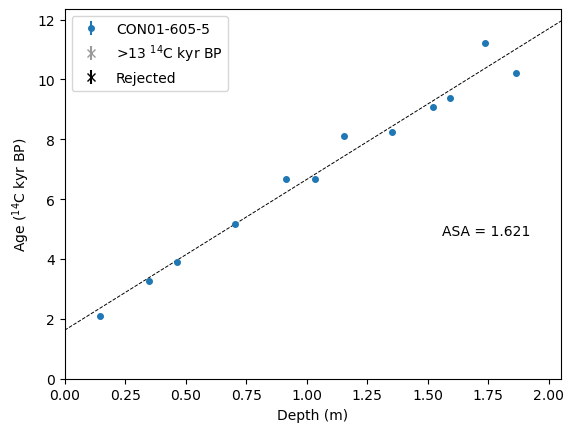

In [351]:
asaVStoc_opt1 = ASA13_grey(['CON01-605-5'],[],dfall)


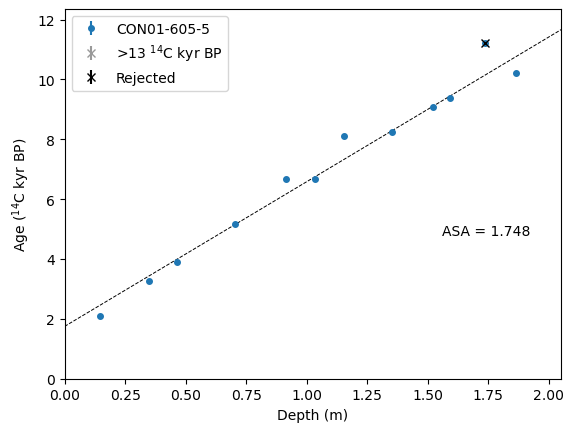

In [352]:
asaVStoc_opt2 = ASA13_grey(['CON01-605-5'],['GdA-719'],dfall)


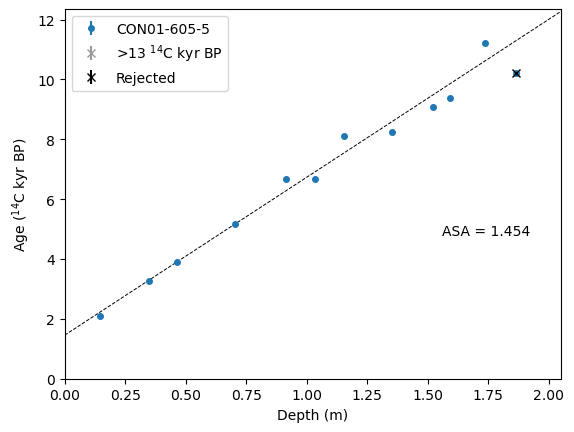

In [353]:
asaVStoc_opt3 = ASA13_grey(['CON01-605-5'],['GdA-720'],dfall)


We will use option 1 in our analysis.

#### Northern Basin

The basins typically aren't cored for paleolimnological study because they often experience large turbiditic activity which renders the sediments non-continuously deposited and therefore not ideal for such study. 

There are 2 cores from the Northern Basin: 323-PC1 and VER94-5 St.22-GC.

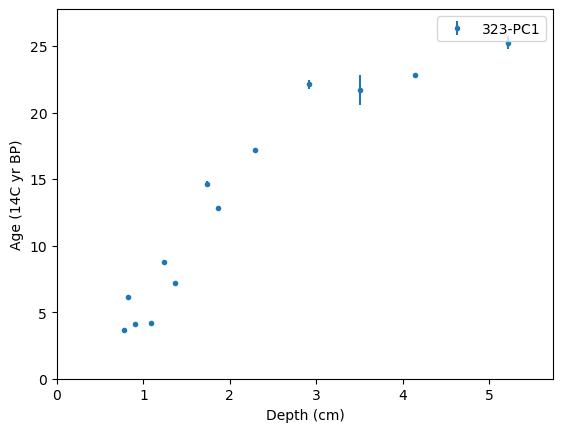

In [354]:
compiplot(['323-PC1'],[],dfall)

There is a very approximate linear pattern shown over the shallowest 300cm of the core. Looking at the data younger than 13 14C ky BP, there are many instances that violate the law of superposition and it is not clear which ages should be rejected or kept. So we run linear regression without rejecting any.

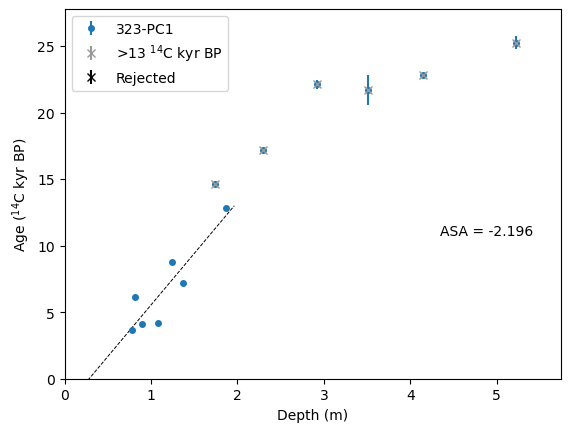

In [355]:
asa323 = ASA13_grey(['323-PC1'],[],dfall)

The non-linear set of ages younger than 13 14C ky BP, and the large negative ASA, suggests that this is not an informative result so we will not use it.

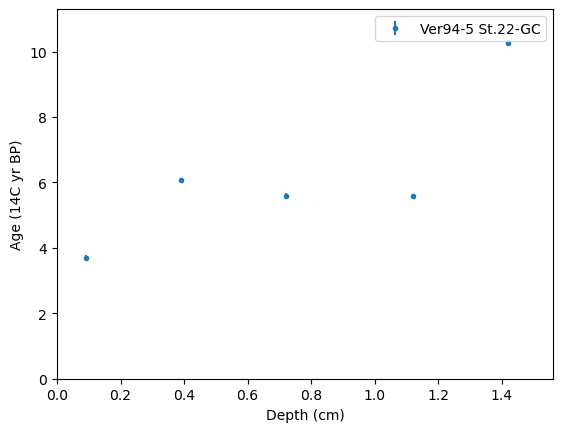

In [366]:
compiplot(['Ver94-5 St.22-GC'],[],dfall)

Core VER94-5 St.22-GC has some ages that violate the law of superposition. It is not clear that the sedimentation rate in this core was consistent over this time period. We consider the four following options:
- Option 1 - Use all ages
- Option 2,3,4 - Use 1 of the middle ages, reject the other two (3 possible permutations of this).


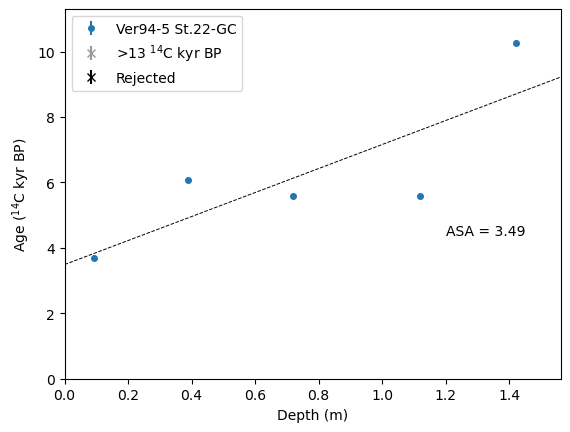

In [361]:
asaVER94st22_opt1 = ASA13_grey(['Ver94-5 St.22-GC'], [],dfall)

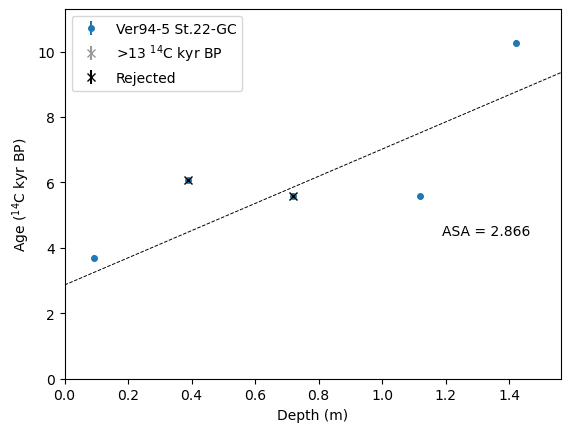

In [362]:
asaVER94st22_opt2 = ASA13_grey(['Ver94-5 St.22-GC'], ['NUTA-4106', 'NUTA-5540'],dfall)

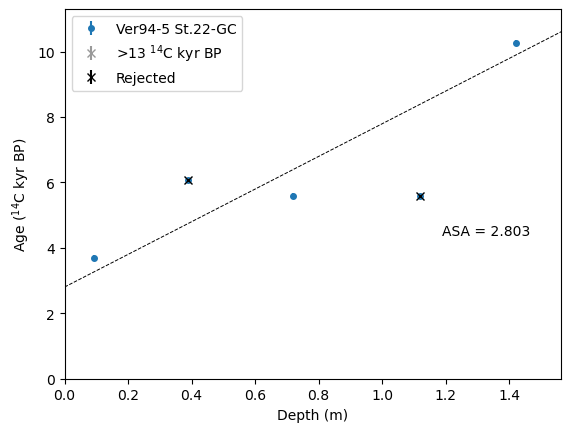

In [363]:
asaVER94st22_opt3 = ASA13_grey(['Ver94-5 St.22-GC'], ['NUTA-4106', 'NUTA-5498'],dfall)

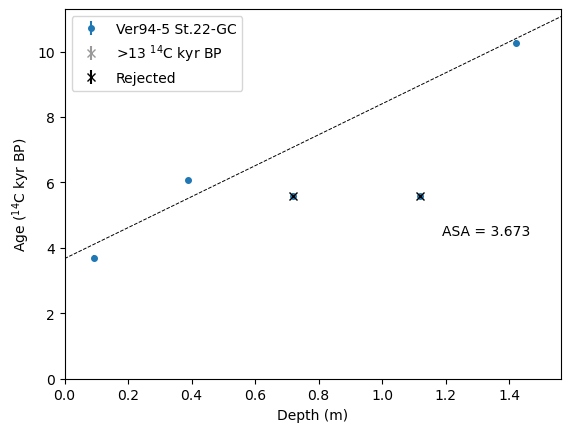

In [364]:
asaVER94st22_opt4 = ASA13_grey(['Ver94-5 St.22-GC'], ['NUTA-5540', 'NUTA-5498'],dfall)

#### Core 308-A3

Core 308-A3 is from the central basin at a depth of 1700m and has dates from TOC, POM and FOM. Colman et al. (1996) suggested that POM and FOM do not show any significant difference to each other, so it may be reasonable to treat them all as TOC ages.

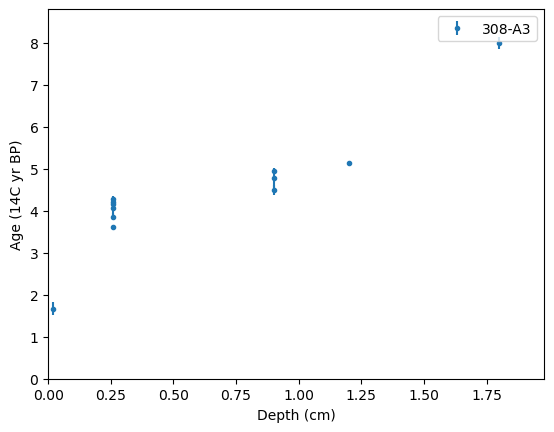

In [395]:
compiplot(['308-A3'],[],dfall)


Some depths have multiple ages, such as the 5 ages at ~25cm, which will overly impact the result. We consider three options:
- Option 1 - Use all dates
- Option 2 - Choose 1 date from each depth such that it minimizes the intercept
- Option 3 - Choose 1 date from each depth such that it maximizes the intercept
- Option 4 - Only use the TOC dates, not the FOM or POM dates.

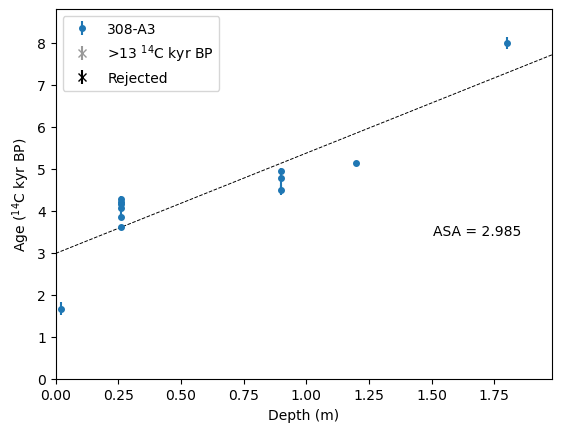

In [396]:
asa308_opt1= ASA13_grey(['308-A3'],[],dfall)


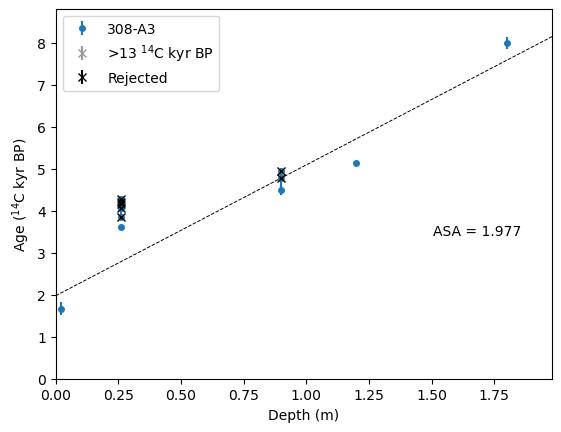

In [397]:
asa308_opt2= ASA13_grey(['308-A3'],['OS-00127', 'OS-00064', 'OS-00824', 'OS-00111', 'OS-00112', 'OS-00110', 'OS-00825'],dfall)


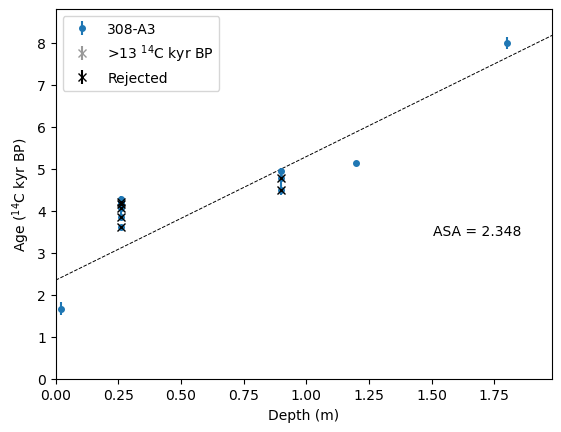

In [401]:
asa308_opt3= ASA13_grey(['308-A3'],['OS-00127', 'OS-00064', 'OS-00126', 'OS-00111', 'OS-00112', 'OS-00110', 'OS-00113'], dfall)


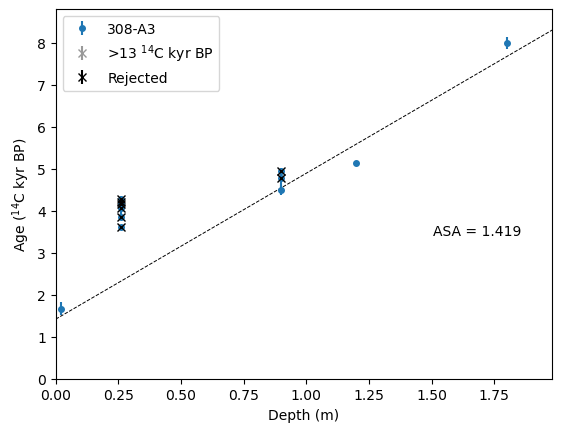

In [402]:
asa308_opt4= ASA13_grey(['308-A3'],['OS-00126','OS-00127', 'OS-00064', 'OS-00824', 'OS-00111', 'OS-00112', 'OS-00110', 'OS-00825'],dfall)


#### Southern Basin

There are three cores from the Southern Basin: BAIK13-1C, BAIK13-4F, and BDP97-1

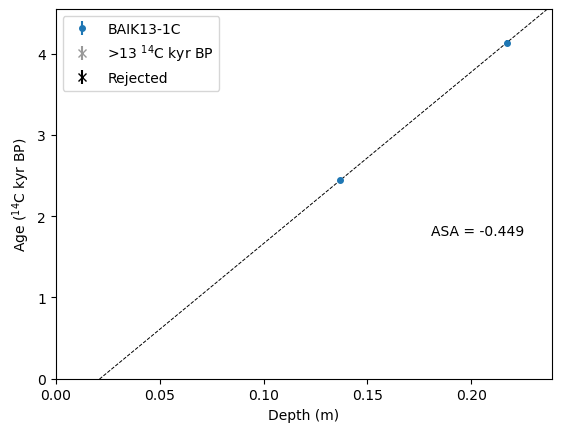

In [403]:
asaBAIK13_1C = ASA13_grey(['BAIK13-1C'],[],dfall)

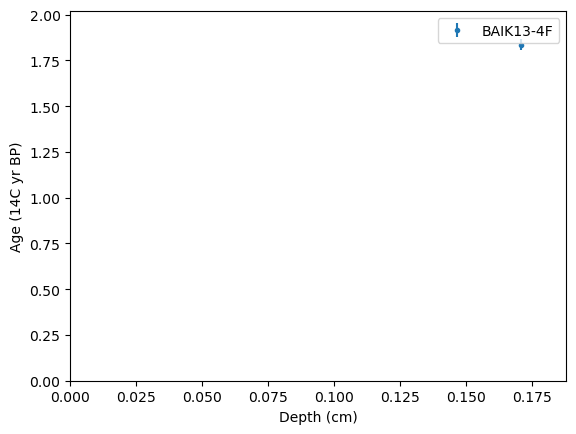

In [404]:
compiplot(['BAIK13-4F'],[],dfall)

Core BAIK13-4F has only one radiocarbon age, so we cannot estimate an apparent surface age from this data.

#### BDP97

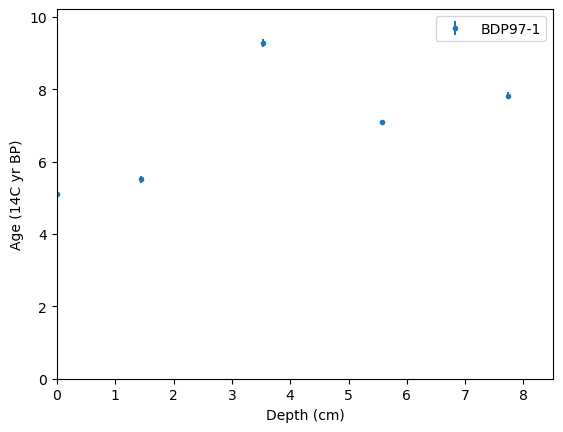

In [405]:
compiplot(['BDP97-1'],[],dfall)

Core BDP97-1 has some ages that violate the law of superposition. Based on the linear pattern suggested by the 4 younger dates, it seems like the middle date between 300 and 400 cm may not be reliable. We consider two options here:
- Option 1 - use all dates
- Option 2 - remove the date between 300 and 400 cm

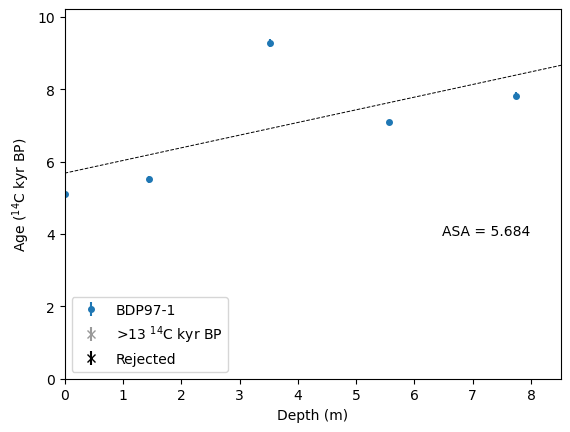

In [406]:
asaBDP97_opt1 = ASA13_grey(['BDP97-1'], [],dfall)


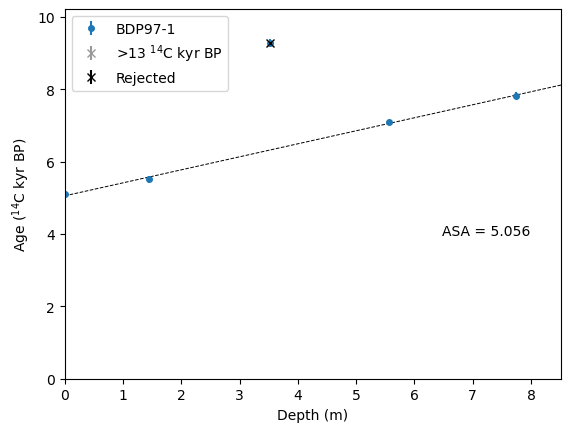

In [407]:
asaBDP97_opt2 = ASA13_grey(['BDP97-1'], ['NUTA2-0029'],dfall)


The ASA values from BDP97-1 are both much greater than most of the other values we have been finding. Two possible explanations for this are:
- The TOC in this core truly has a much greater age offset than the other cores we've looked.
- This core has a significant amount of top sediment missing, such that the top of the sediment is not truly representative of modern sediment. This sediment may be missing due to incomplete coring or because it was eroded (or never deposited) due to changes in sedimentation rates.

We believe that it is most likely that the core has significant surface sediment missing due to incomplete coring, erosion or lack of deposition.

#### Other Locations Overview

Site 342 (Maloe More) returned an ASA of 501 14C y BP.

Core CON01-603-5 (Continent Ridge) returned ASAs ranging from 1692 to 1959 14C y BP depending on what subset of ages were used. We will use the ASA that used all TOC ages, which was 1893 14C y BP.

Core Ver.99 G-6 (Posolskoe Bank) returned an ASA of 1192 14C y BP.

Site CON01-605 (Vydrino Shoulder) retunred ASAs ranging from 1454 to 1749 depending on what subset of ages were used. We will use the ASA that used all TOC ages, which was 1621 14C y BP.

Core 323-PC1 returned an ASA of -2197 14C y BP. We will reject this answer (either the dates were not good enough quality or sedimentation has not been constant throughout the last 13 14C kyr.

Core VER94-5 St.22-GC returned ASAs ranging from 2803 to 3673 14C y BP depending on what ages were rejected. We will use the ASA that used the first, third, and last TOC age, which was 2803 14C y BP.

Core 308-A3 returned ASAs ranging from 1419 to 2985 14C y BP depending on what subset of ages were used. We will use the estimate that used only the TOC estimates.

Core BAIK13-1C returned an ASA of -449.12, so we reject this answer.

Core BAIK13-4F does not have enough radiocarbon ages to return an ASA.

Core BDP97-1 returned an ASA of 5056 14C y BP. We believe this significantly larger value (than other ASAs) suggests that a large portion of the core top is missing, hence we reject this answer.



## Whole Lake

Having looked at the ASAs and estimates of age offset with a focus on sections of the lake, let us look take a whole lake view on estimating age offset. This approach is not likely to be as useful as the more partitioned approach however, as that incorporates greater information regarding the sedimentary conditions of the lake.

In [410]:
import statistics

other_asas = [asaVStoc_opt1, asaPBtoc, asaCRtoc1, asa342, asa308_opt4, asaVER94st22_opt3]
AllASAs = BS_asas + AR_asas + other_asas
AllASAs_mean = statistics.mean(AllASAs)
AllASAs_std = statistics.stdev(AllASAs)
AllASAs_range = max(AllASAs)-min(AllASAs)
print('The mean apparent surface age across the whole lake is '+ str(round(AllASAs_mean,2))+' 14C kyr BP with a standard deviation of ' + str(round(AllASAs_std,2))+ ' and a range of ' +str(round(AllASAs_range, 2))+' 14C kyr BP, as calculated from ' + str(len(AllASAs))+ ' sites.')

The mean apparent surface age across the whole lake is 1.61 14C kyr BP with a standard deviation of 0.76 and a range of 2.78 14C kyr BP, as calculated from 21 sites.


In [411]:
statistics.stdev(other_asas)

0.7664755610998178

# T Test

Perform Welch's T Test to see if we can reject the null hypothesis that the age offset at Academician Ridge is different to Buguldeika Saddle.

In [412]:
import statistics
import numpy as np
import pandas as pd
import scipy
from scipy import stats

meanBS = statistics.mean(BS_asas)
meanAR = statistics.mean(AR_asas)

stdBS = statistics.stdev(BS_asas)
stdAR = statistics.stdev(AR_asas)

nBS = len(BS_asas)
nAR = len(AR_asas)

#t_test = (meanBS - meanAR)/((stdBS**2/nBS + stdAR**2/nAR)**0.5)

t, p = stats.ttest_ind(BS_asas, AR_asas, equal_var = False)

print(p)

0.44462077378467535


We cannot reject the null hypothesis, therefore there is no statistical evidence that the age offset at Academician Ridge is different to the age offset at Buguldieka Saddle.

# ASA Comparison Figure

Reviewer 1 suggested that the manuscript would benefit from a figure that communicates the results. The main results are the ASA results from each site, their average value and the uncertainty, and how they compare to each other.

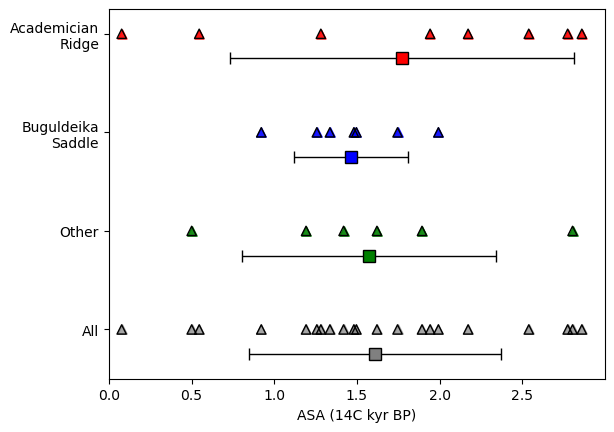

In [413]:
import statistics

#Construction of plot done with assistance from ChatGPT 5 (Thinking)

def plot_asas(AR_asas, BS_asas, other_asas,
              x_label="ASA (units)",
              title=""):
    """
    Creates a horizontal strip-plot comparing ASA values
    from three site categories (AR, BS, Other) plus all points.

    Parameters
    ----------
    AR_asas : array-like
        ASA values for Academician Ridge cores
    BS_asas : array-like
        ASA values for Buguldeika Saddle cores
    other_asas : array-like
        ASA values for other cores
    x_label : str, optional
        Label for the x-axis
    title : str, optional
        Title for the figure
    """

    # Convert to numpy arrays
    AR_asas = np.asarray(AR_asas, dtype=float)
    BS_asas = np.asarray(BS_asas, dtype=float)
    other_asas = np.asarray(other_asas, dtype=float)
    all_asas = np.concatenate([AR_asas, BS_asas, other_asas])
    
    # Calculate mean and std
    meanBS = statistics.mean(BS_asas)
    meanAR = statistics.mean(AR_asas)
    meanOther = statistics.mean(other_asas)
    meanAll = statistics.mean(all_asas)

    stdBS = statistics.stdev(BS_asas)
    stdAR = statistics.stdev(AR_asas)
    stdOther=statistics.stdev(other_asas)
    stdAll=statistics.stdev(all_asas)

    # y levels: AR=4, BS=3, Other=2, All=1
    y_ar = np.full_like(AR_asas, 4, dtype=float)
    y_bs = np.full_like(BS_asas, 3, dtype=float)
    y_other = np.full_like(other_asas, 2, dtype=float)
    y_all = np.full_like(all_asas, 1, dtype=float)

    # Tiny jitter so overlapping points are visible
    rng = np.random.default_rng(1)
    jitter = lambda n: rng.normal(0, 0.00000000001, size=n)

    jitterAR = jitter(len(y_ar));
    plt.scatter(AR_asas, y_ar + jitterAR, s=42, marker='^',
                facecolors='red', edgecolors='face', alpha=0.9, label="AR")
    plt.scatter(AR_asas, y_ar + jitterAR, s=45, marker='^',
                facecolors='none', edgecolors='black', alpha=1, label="AR")
    
    jitterBS = jitter(len(y_bs))
    plt.scatter(BS_asas, y_bs + jitterBS, s=45, marker='^',
                facecolors='blue', edgecolors='face', alpha=0.9, label="BS")
    plt.scatter(BS_asas, y_bs + jitterBS, s=45, marker='^',
                facecolors='none', edgecolors='black', alpha=1, label="BS")
    
    jitterOther = jitter(len(y_other))
    plt.scatter(other_asas, y_other + jitterOther, s=45, marker='^',
                facecolors='green', edgecolors='face', alpha=0.9, label="Other")
    plt.scatter(other_asas, y_other + jitterOther, s=45, marker='^',
                facecolors='none', edgecolors='black', alpha=1, label="Other")
    
    jitterAll = jitter(len(y_all))
    plt.scatter(all_asas, y_all + jitterAll, s=45, marker='^',
                facecolors='gray', edgecolors='face', alpha=0.7, label="All")
    plt.scatter(all_asas, y_all + jitterAll, s=45, marker='^',
                facecolors='none', edgecolors='black', alpha=1, label="All")
    

    plt.errorbar(meanAR, y_ar[1]-0.25, xerr=stdAR, fmt='s',
             markersize=8, markerfacecolor='red', markeredgecolor='black',
             ecolor='black', elinewidth=1, capsize=4, alpha=1)

    plt.errorbar(meanBS, y_bs[1]-0.25, xerr=stdBS, fmt='s',
             markersize=8, markerfacecolor='blue', markeredgecolor='black',
             ecolor='black', elinewidth=1, capsize=4, alpha=1)

    plt.errorbar(meanOther, y_other[1]-0.25, xerr=stdOther, fmt='s',
             markersize=8, markerfacecolor='green', markeredgecolor='black',
             ecolor='black', elinewidth=1, capsize=4, alpha=1)

    plt.errorbar(meanAll, y_all[1]-0.25, xerr=stdAll, fmt='s',
             markersize=8, markerfacecolor='grey', markeredgecolor='black',
             ecolor='black', elinewidth=1, capsize=4, alpha=1)

    # Axes formatting
    plt.yticks([1, 2, 3, 4], ["All", "Other", "Buguldeika\nSaddle", "Academician\nRidge"])
    nanmin = np.nanmin(all_asas)
    nanmax = np.nanmax(all_asas)
    span = nanmax - nanmin if np.isfinite(nanmax - nanmin) else 1.0
    xmin = max(0, nanmin - 0.05 * span)
    xmax = nanmax + 0.05 * span
    plt.xlim(xmin, xmax)
    plt.ylim(0.5, 4.25)
    plt.xlabel(x_label)
    plt.title(title)
    #plt.tight_layout()
    plt.savefig("ASAcomparison.png", dpi=300, bbox_inches="tight")
    plt.show()
    
plot_asas(AR_asas, BS_asas, other_asas, x_label="ASA (14C kyr BP)", title="")


In plotting the confidence intervals symmetrically we are assuming that the data are symmetrically distributed around the mean. A simple such assumption is that the data are normally distributed. To ensure that this is a reasonable assumption, let us run the Shapiro-Wilks test, which tests the null hypothesis that the data are normally distributed, for each subset of data.

In [414]:
SWstatAR, SWpAR = stats.shapiro(AR_asas)
SWstatBS, SWpBS = stats.shapiro(BS_asas)
SWstatOther, SWpOther = stats.shapiro(other_asas)
SWstatAll, SWpAll = stats.shapiro(AllASAs)

print("Shapiro-Wilk statistics:\n"+ f"AR data: test: {SWstatAR:.4f}, p-value: {SWpAR:.4f}\n"
      + f"BS data: test: {SWstatBS:.4f}, p-value: {SWpBS:.4f}\n"
      + f"Other data: test: {SWstatOther:.4f}, p-value: {SWpOther:.4f}\n"
      + f"All data: test: {SWstatAll:.4f}, p-value: {SWpAll:.4f}\n")

Shapiro-Wilk statistics:
AR data: test: 0.9066, p-value: 0.3309
BS data: test: 0.9844, p-value: 0.9782
Other data: test: 0.9783, p-value: 0.9430
All data: test: 0.9679, p-value: 0.6857



At the 0.05-confidence level there is no evidence to reject the hypothesis that each dataset are normally distributed, so the use of symmetrical error bars is reasonable, and we interpret the 1-sigma interval to represent the 68% confidence intervals. 